In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import scipy.stats as stats

from scipy.interpolate import griddata

<a id='initialArvizParams'></a>Initialize the Arviz paramaters for some defaults.

In [3]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
az.rcParams["stats.hdi_prob"] = 0.89  # sets default credible interval used by arviz

#### Simulation of field trip

#### Code 4.1

This will generate 16*10000 values, and sum them along the `0` axis.  That will then represent the position at the end of 16 samples from the interval [-1, 1] for each of 10000 trials.

In [4]:
pos = rng.uniform(-1, 1, size=(16, 1000)).sum(0)

If we want to replicate the Figure 4.2 we can do the following to generate the top plot:

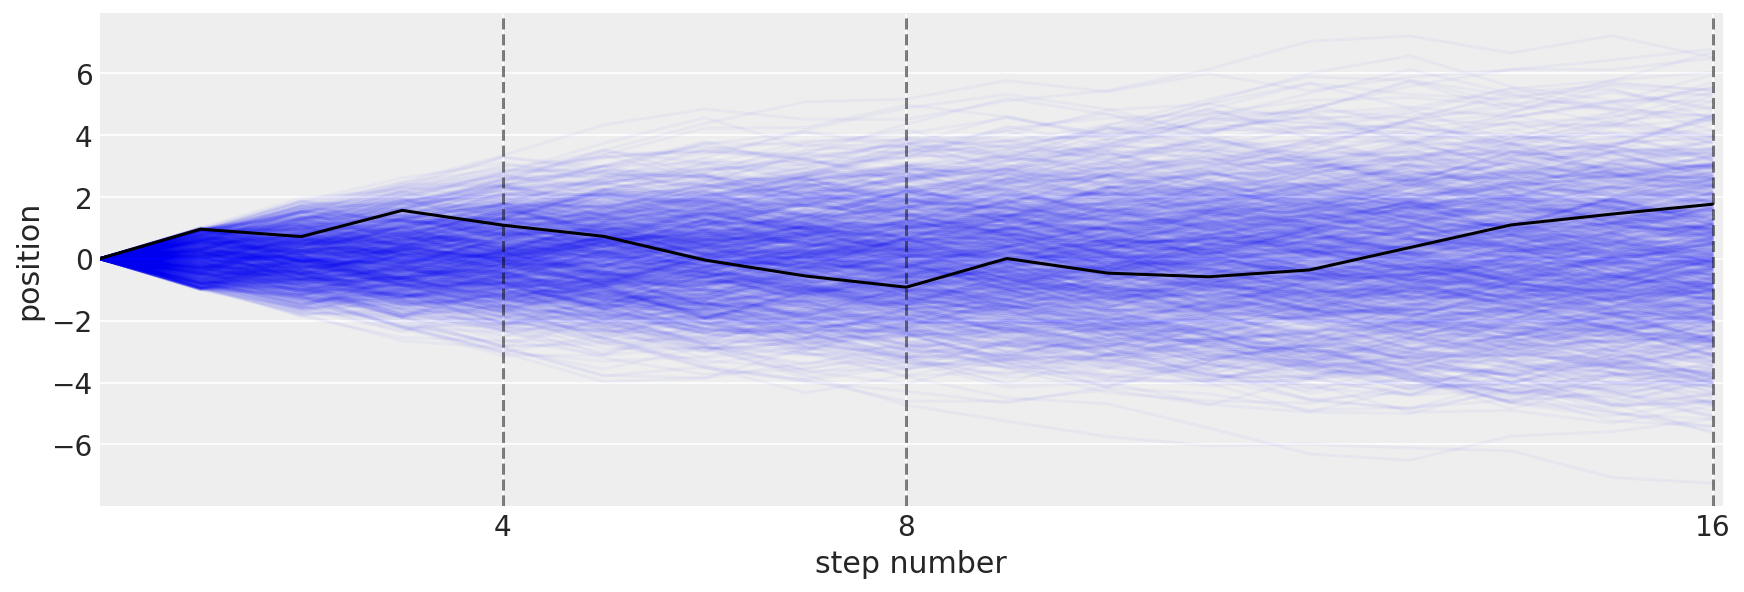

In [5]:
# get a concrete instance of the python default random number generator
# with a particular seed value
step_rng = np.random.default_rng(1234)

steps = 16
repetitions = 1000
# we want to be able to see the distribution at these points
show_steps = [4, 8, 16]
# create a matrix of values that will store rows of:
# 0 followed by the cumulative sum of 16 values 
# randomly selected from the interval [-1, 1] 
x = np.zeros([steps + 1, repetitions])

for i in range(repetitions):
    # store the cumulative sum of steps as we generate them
    x[1:, i] = np.cumsum(step_rng.uniform(-1, 1, steps))

fig, ax = plt.subplots(figsize=(12,4))
plt.plot(range(0, steps + 1), x[:, :], c="blue", alpha=0.03)
plt.plot(range(0, steps + 1), x[:, 0], c="k")
for step in show_steps:
    plt.axvline(step, linestyle="--", c="k", alpha=0.5)

plt.xlabel("step number")
plt.ylabel("position")
ax.set_xticks(show_steps)
plt.xlim(0, step + 0.1)
plt.show()

And the second row can be generated like this:

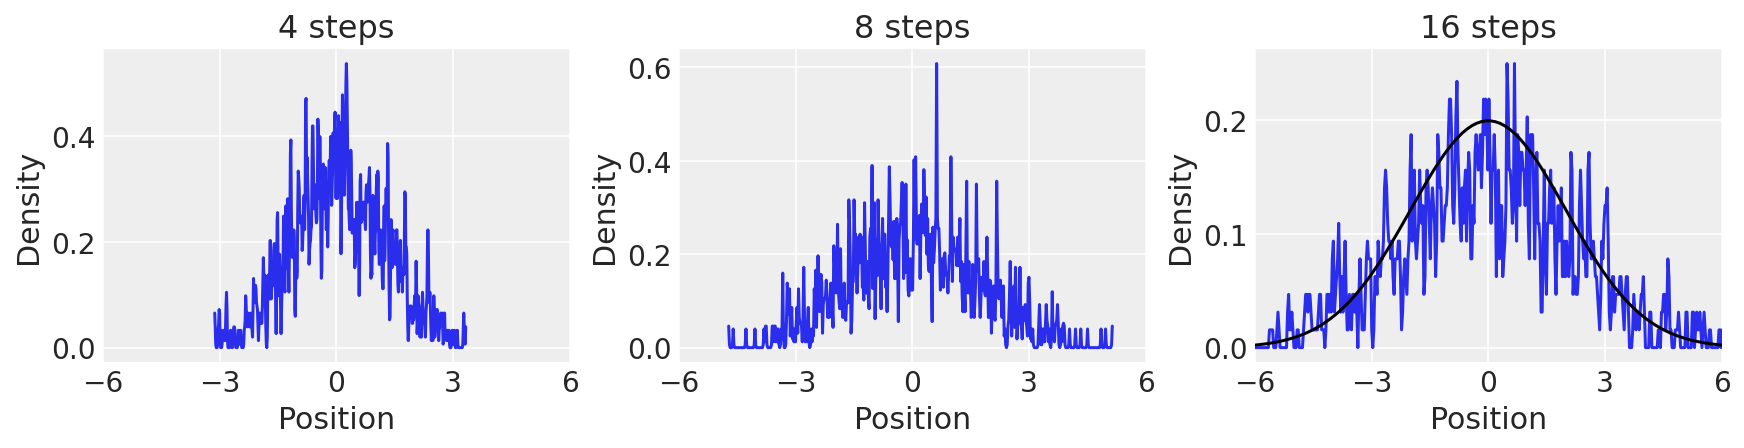

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

# draw the kernel density estimates for the three steps that we want to look at.
for step, ax in zip(show_steps, axs):
    az.plot_kde(x[step, :], bw=0.01, ax=ax)
    ax.set_title(f"{step} steps")
    ax.set_ylabel("Density")
    ax.set_xlabel("Position")
    ax.set_xlim(-6, 6)
    ax.set_xticks([-6, -3, 0, 3, 6])
# draw the normal distribution overlay on the step 16 figure
x1 = np.linspace(-6, 6, 100)
# estimate the standard deviation from the data at step 16
std = np.std(x[16,:])
axs[2].plot(x1, stats.norm.pdf(x1, scale=2), color='black')

#### Code 4.2 and 4.3

As above we can generate 10,000 trials with 12 random values selected from the interval [1.0, 1.1] and this time take the product along the rows.

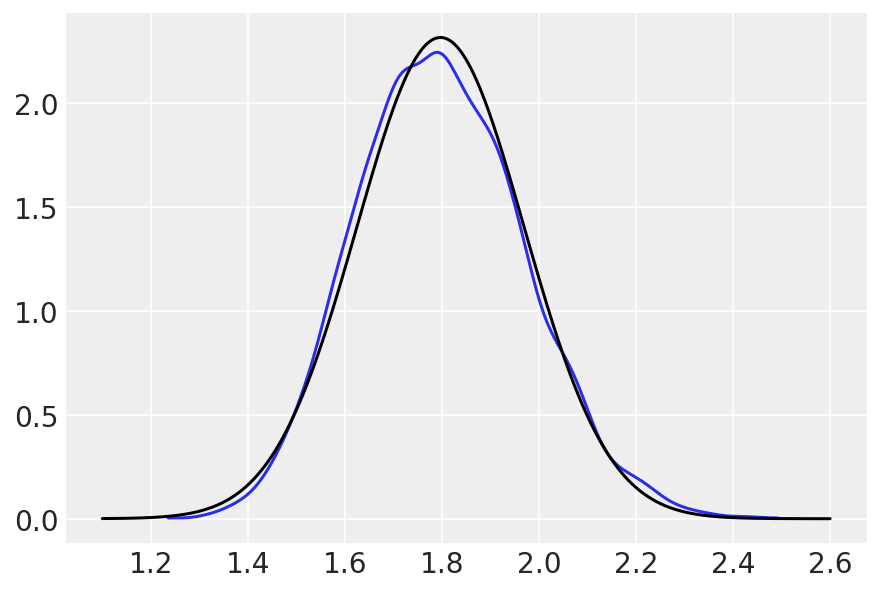

In [7]:
# 4.2
growth = rng.uniform(1, 1.1, size=(12, 10000)).prod(0)
# 4.3
# we get most of what we need from this
az.plot_kde(growth)
# however the text uses the norm.comp = TRUE setting so will overlay a normal plot fit to the same data.
mu = np.mean(growth)
sigma = np.std(growth)
x = np.linspace(1.1, 2.6, 1000)
plt.plot(x, stats.norm.pdf(x, loc=mu, scale=sigma), color='black')

#### Code 4.4

Let's verify that for small values of $\delta _i$ we have this approximation $$(1 + \delta_1) \times (1 + \delta_2) \sim 1 + \delta _1 + \delta _2$$

<AxesSubplot: >

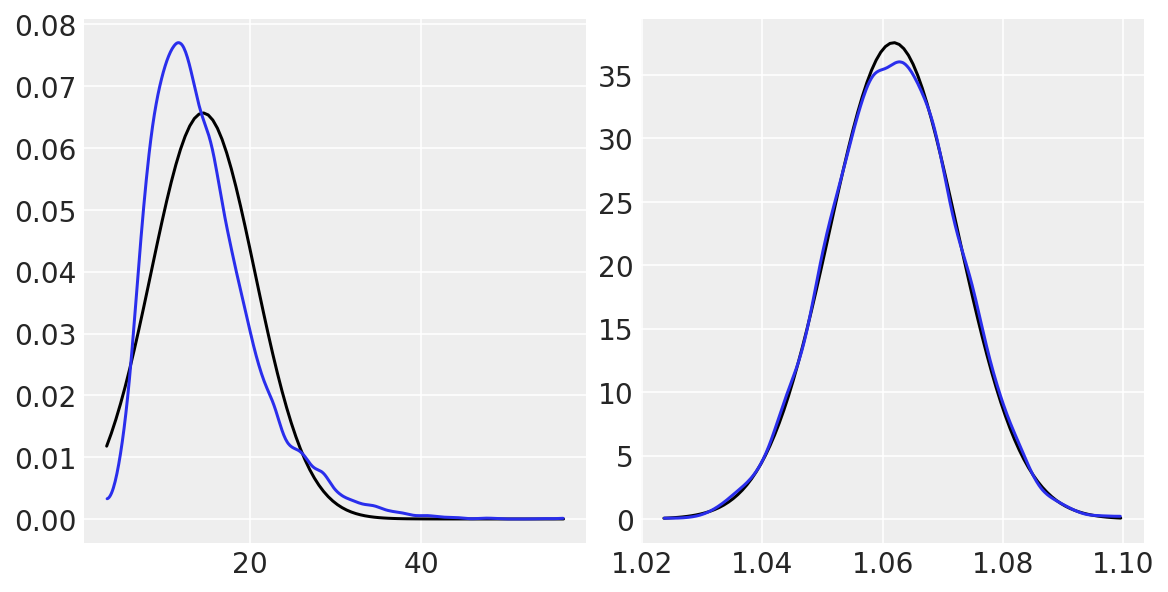

In [8]:
big = rng.uniform(1, 1.5, size=(12, 10000)).prod(0)
small = rng.uniform(1, 1.01, size=(12, 10000)).prod(0)
_, ax = plt.subplots(1, 2, figsize=(8, 4))
for i, data in enumerate([big, small]):
    x = np.linspace(np.min(data), np.max(data), 100)
    m = np.mean(data)
    s = np.std(data)
    ax[i].plot(x, stats.norm.pdf(x, loc=m, scale=s), color='black')
az.plot_kde(big, ax=ax[0])
az.plot_kde(small, ax=ax[1])


#### Code 4.5

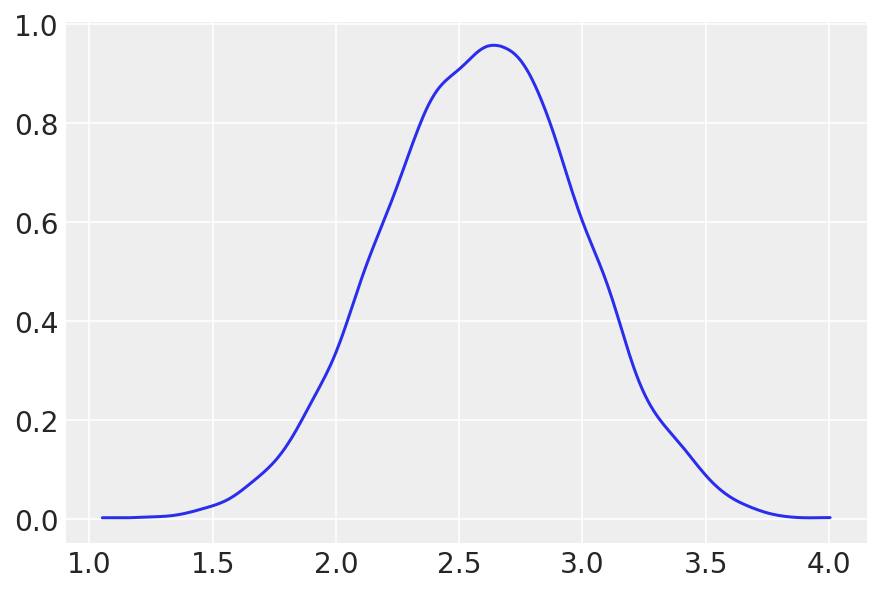

In [9]:
log_big = np.log(rng.uniform(1, 1.5, size=(12, 10000)).prod(0))
az.plot_kde(log_big);

Overthinking: Gausian distribution 

$$P(y \mid \mu,\sigma) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left( - \frac{(y-\sigma)^2}{2\sigma^2}\right)$$

#### Code 4.6

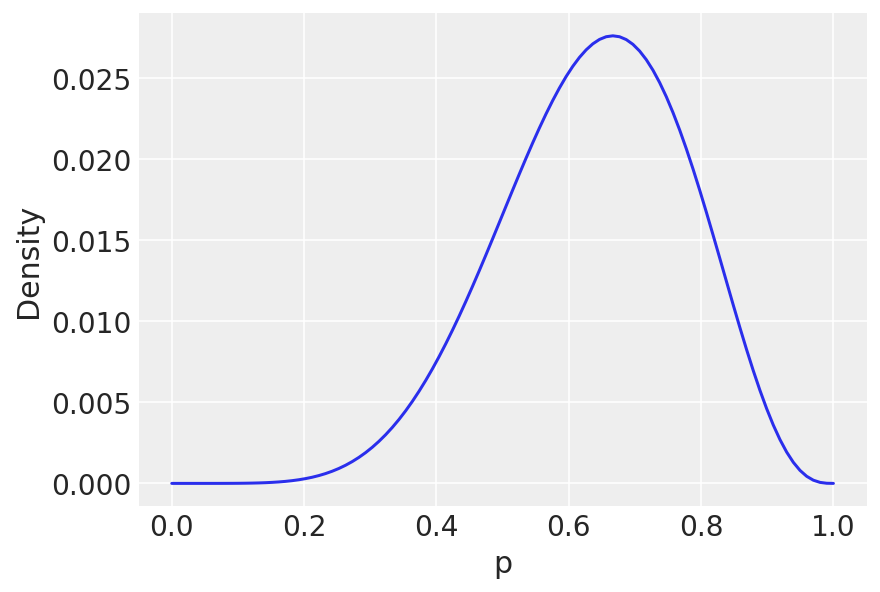

In [10]:
w, n = 6, 9
p_grid = np.linspace(0, 1, 100)
posterior = stats.binom.pmf(k=w, n=n, p=p_grid) * stats.uniform.pdf(p_grid, 0, 1)
posterior = posterior / (posterior).sum()
plt.plot(p_grid, posterior)
plt.xlabel("p")
plt.ylabel("Density");

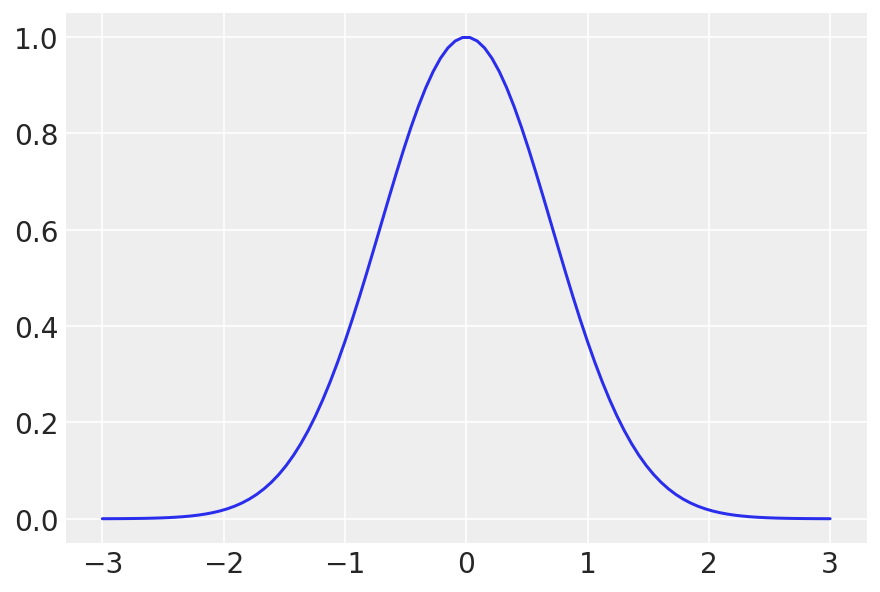

In [11]:
x = np.linspace(-3, 3, 100)
plt.plot(x, np.exp(-x**2))

#### Code 4.7 and 4.8

The Pandas DataFrame is much like the R DataFrame in that you think of them both as a table with named columns and rows.

In [12]:
# read the data into a Pandas DataFrame
# Despite it being stored as a .csv file, the separator is actually a `;`
# the first row is a header row.
# 4.7
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
#4.8
d.head()

height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0

You can get some classical summary statistics easily.

In [13]:
d.describe()

height      weight         age        male
count  544.000000  544.000000  544.000000  544.000000
mean   138.263596   35.610618   29.344393    0.472426
std     27.602448   14.719178   20.746888    0.499699
min     53.975000    4.252425    0.000000    0.000000
25%    125.095000   22.007717   12.000000    0.000000
50%    148.590000   40.057844   27.000000    0.000000
75%    157.480000   47.209005   43.000000    1.000000
max    179.070000   62.992589   88.000000    1.000000

And a quick histogram all on one figure

array([<AxesSubplot: title={'center': '0'}, ylabel='Frequency'>,
       <AxesSubplot: title={'center': '1'}, ylabel='Frequency'>],
      dtype=object)

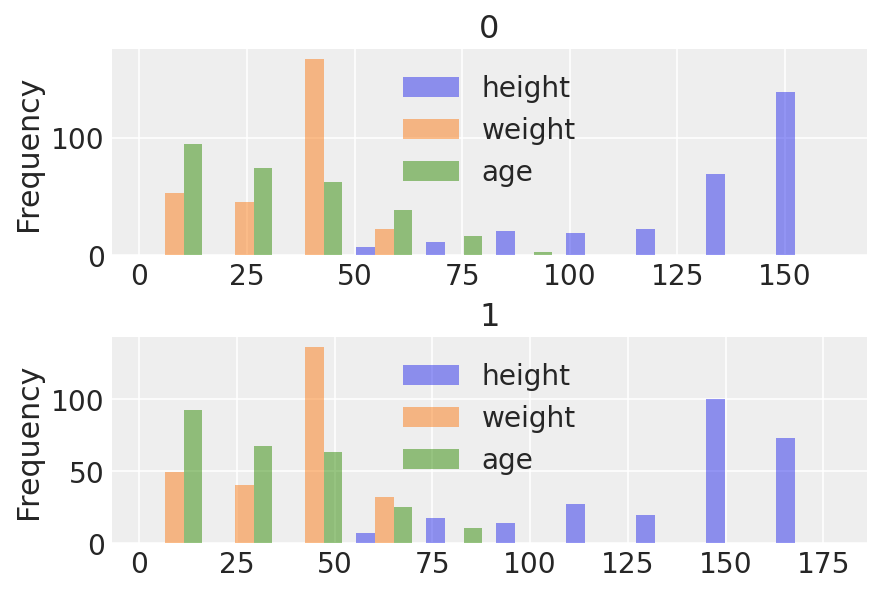

In [14]:
d.plot.hist(column=['height', 'weight', 'age'], alpha=0.5, by='male')

#### Code 4.9

If we want to see Highest Density Intervals we can use the `arviz.summary` function.  One caveat is that we first have to convert the Pandas DataFrame `d` into a dictionary of lists indexed by the column name in order for `arviz.summary` to be able to process it.

In [15]:
az.summary(d.to_dict(orient="list"), kind="stats")

mean      sd  hdi_5.5%  hdi_94.5%
height  138.264  27.602    90.805    170.180
weight   35.611  14.719    11.368     55.707
age      29.344  20.747     0.000     57.000
male      0.472   0.500     0.000      1.000

#### Code 4.10

To access a column in a Pandas DataFrame we have a few syntax.  The simplest is to simply refer to the name of a column

In [16]:
d.height

0      151.765
1      139.700
2      136.525
3      156.845
4      145.415
        ...   
539    145.415
540    162.560
541    156.210
542     71.120
543    158.750
Name: height, Length: 544, dtype: float64

But there are other ways to write it.  For example if you need more than one column of your data you can supply a list of column names

In [17]:
d[['height','weight']]

height     weight
0    151.765  47.825606
1    139.700  36.485807
2    136.525  31.864838
3    156.845  53.041914
4    145.415  41.276872
..       ...        ...
539  145.415  31.127751
540  162.560  52.163080
541  156.210  54.062497
542   71.120   8.051258
543  158.750  52.531624

[544 rows x 2 columns]

#### Code 4.11

Taking subsets of a DataFrame is similar in Pandas to R.  The following code should be read as 'return all the rows in the DataFrame where age is greater than or equal to 18'.  The `.shape` attribute of the dataframe stores the shape.  We get 352 rows (individuals) and four columns.

In [18]:
d2 = d[d.age >= 18]
d2.shape

(352, 4)

### 4.3.2 The model.

Plot the height for subjects that are over 18.

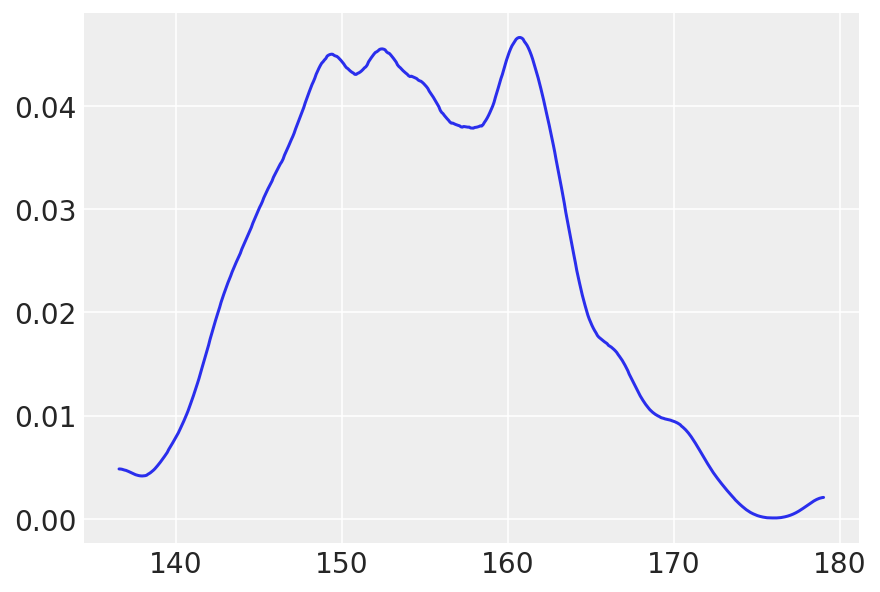

In [19]:
az.plot_kde(d2.height);

#### Code 4.12

Plotting our priors: code to generate the upper left portion of Figure 4.3, or the prior distribution of mean height using a height of 178cm and a standard deviation of 20.

Text(0.5, 1.0, '$\\mu \\sim $ stats.norm(178, 20)')

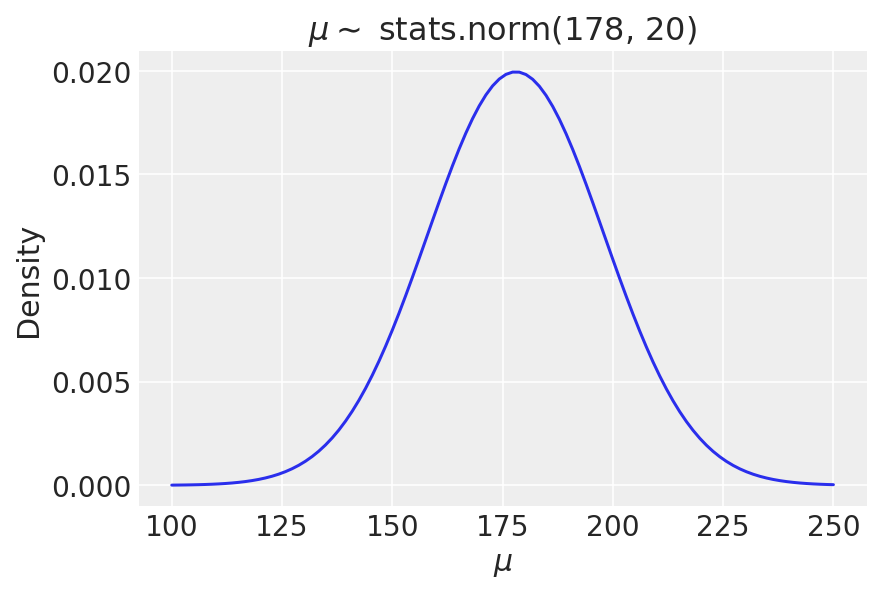

In [20]:
x = np.linspace(100, 250, 100)
# for normal distribution loc is the mean, and scale is the standard deviationn
plt.plot(x, stats.norm.pdf(x, loc=178, scale=20))
plt.xlabel("$\mu$")
plt.ylabel("Density")
plt.title("$\mu \sim $ stats.norm(178, 20)")

#### Code 4.13

Code to generate the upper right portion of Figure 4.3.  That is our uniform prior of 50 on the standard deviation of height.

Text(0.5, 1.0, '$\\sigma \\sim $ stats.uniform(0, 50)')

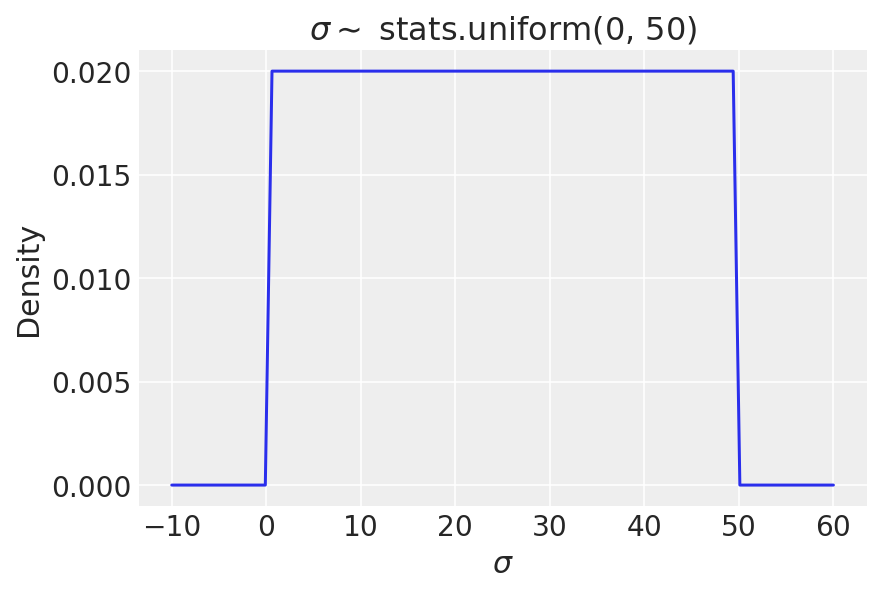

In [21]:
x = np.linspace(-10, 60, 100)
# for uniform distribution loc is the left boundary, and loc + scale is the right boundary
plt.plot(x, stats.uniform.pdf(x, loc=0, scale=50))
plt.xlabel("$\sigma$")
plt.ylabel("Density")
plt.title("$\sigma \sim $ stats.uniform(0, 50)")

#### Code 4.14

We want 10,000 samples of $\mu$ and $\sigma$ from their respective prior distributions and use those values to simulate heights.

The [`stats.norm.rvs()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) function returns random variates from the normal distribution.  We specify which normal distribution by passing in the paramaters `loc=mu`, `scale=sigma` and `size=num_samples` .  That is it will return `size=num_samples` numbers drawn from a probability distribution with mean of `mu=178` and standard deviation `scale=20`. Similarly the uniform distribution can return random variates via `stats.uniform.rvs()`.  That is it will return `size=num_samples` numbers that are equaly liekely to be chosen between 0, and 50.  So now we have two collections, one with random $\mu$ and one with random $\sigma$.  Let's use those to generate simulated observations.  `stats.norm.rvs()` can take arrays as inputs to the `loc=` and `scale=` paramaters so if we pass our sampled values for $\mu$ and $\sigma$ we will get 10,000 random samples that ilustrates the uncertainty of our priors.  

Text(0.5, 1.0, 'Simulated Prior\nh $\\sim$ stats.norm(mu, sigma)')

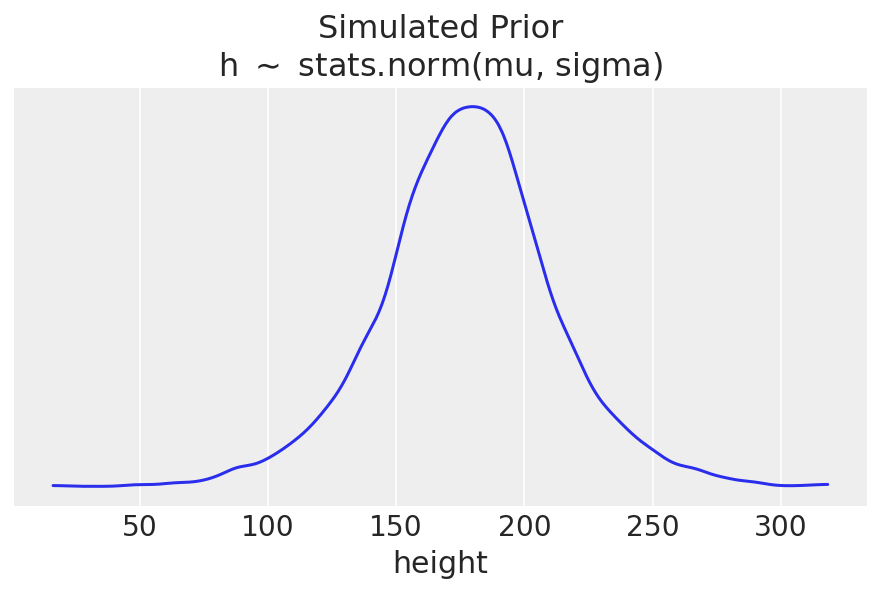

In [22]:
n_samples = 10000
sample_mu = stats.norm.rvs(loc=178, scale=20, size=n_samples)
sample_sigma = stats.uniform.rvs(loc=0, scale=50, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.xlabel("height")
plt.yticks([]);
plt.title("Simulated Prior\nh $\sim$ stats.norm(mu, sigma)")

#### Code 4.15

Re-running our simulation but with a standard deviation of 100, rather than 10.

Text(0.5, 1.0, 'h ~ stats.norm(mu, sigma)\n mu ~ stats.norm(178, 100) ')

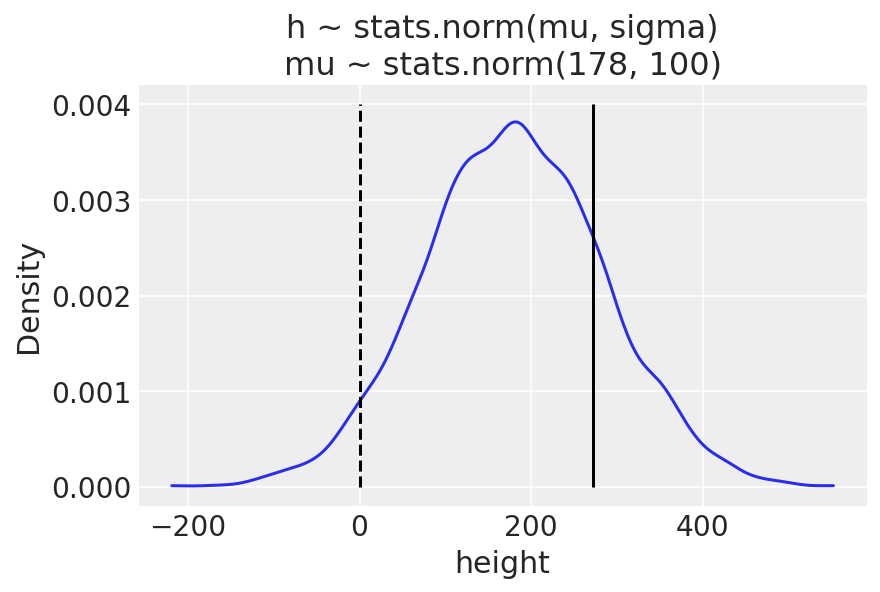

In [23]:
n_samples = 10000
sample_mu = stats.norm.rvs(loc=178, scale=100, size=n_samples)
prior_h = stats.norm.rvs(loc=sample_mu, scale=sample_sigma)
az.plot_kde(prior_h)
plt.vlines(0, 0, 0.004, linestyle='dashed', color='black')
plt.vlines(272, 0, 0.004, color='black')
plt.xlabel("height")
plt.ylabel("Density")
plt.title("h ~ stats.norm(mu, sigma)\n mu ~ stats.norm(178, 100) ")

#### Code 4.16

We are going to do a grid search over a range of possible pairs of values that `mu` and `sigma` could take.  We will resrict our search to `sigma` ranging from 7 to 9 in 0.05 increments and `mu` ranging from 150 to 160 in 0.5 increments ( since the mean of our sample is about 155 and the standard deviation in our sample is about 8).

So how do we create that list of values?  One way to do this is to use [`numpy.mgrid()`](https://numpy.org/doc/stable/reference/generated/numpy.mgrid.html) and use [`numpy.reshape()`](https://numpy.org/doc/stable/reference/generated/numpy.reshape.html) to colapse it down to a vector of pairs of `mu` and `sigma`. Having this vecor allows us to itterate over all possible combinations of `mu` and `sigma`.

Now we can define our likelihood function

$$L(\mu, \sigma \mid h_i) = \prod N(h_i \mid \mu, \sigma)$$

This is a compact way to say: To find the value that the likelihood takes at a particular value of $\mu$ and $\sigma$  we take the product of the probabilities of the height $h_i$ given by the current value of $\mu$ and $\sigma$.  Since some of those values are going to be very small we need to be careful.  The product of a number of small quantities becomes very small very fast so to avoid rounding down to zero we use `stats.norm.logpdf` and sum over the probabilities.  We will get out of the log world later.

Next we need to compute a function that is the posterior density.  That function is the likelihood times the priors. Since what we have actually got is the log-likelihood, we use log-priors and add them to the likelihood.  That gives us a "log_posterior".

Lastly we have to get back to (something resembling) probabilities.  If you look at the `post_prod` below you will see that it is all large negative numbers.  That is to be expected since we are looking at the log of small positive numbers (probabilities given by a probability density function).  If we were to do the obvious and apply the reverse transform `np.exp(post_prod)` we will just get all zeros.  To avoid this we can first shift all of the values by subtracting the `max(post_prod)` and then apply the reverse transform.  It is worth noting that while this does give us non-zero values to use, those values are not exactly probabilities, but the author calls them "relative posterior probabilities".

In [24]:
# create a list of pairs of values for mu and sigma where the list is indexed by
# traversing the sigma axis for each value of the mu axis. 
#
#          | |\   |\
#          | | \  | \
#  sigma   | |  \ |  \
#          | |   \|   \
#          +----------------------
# 
#  post[0] = (150,7)
#  post[1] = (150,7.05)
#  ...
#  post[39] = (150,9)
#  post[40] = (150.05, 7)
#  ....
post = np.mgrid[150:160:0.05, 7:9:0.05].reshape(2, -1).T

likelihood = [
    sum(stats.norm.logpdf(d2.height, loc=post[:, 0][i], scale=post[:, 1][i]))
    for i in range(len(post))
]

post_prod = (
    likelihood
    + stats.norm.logpdf(post[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post[:, 1], loc=0, scale=50)
)
post_prob = np.exp(post_prod - max(post_prod))

#### Code 4.17

If we want to use the [`maptplotlib.pyplot.contour`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.contour.html) function we have a couple of options.

- we can use the original grid of values for $\mu$ and $\sigma$ and plot the contours of the `post_prob`
- we can use a different grid of values and make use of the [`scipy.interplolate.griddata()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html) function with the post_prob values to get interpolated z values at our grid points.

Here is the first approach.

(153.0, 156.0)

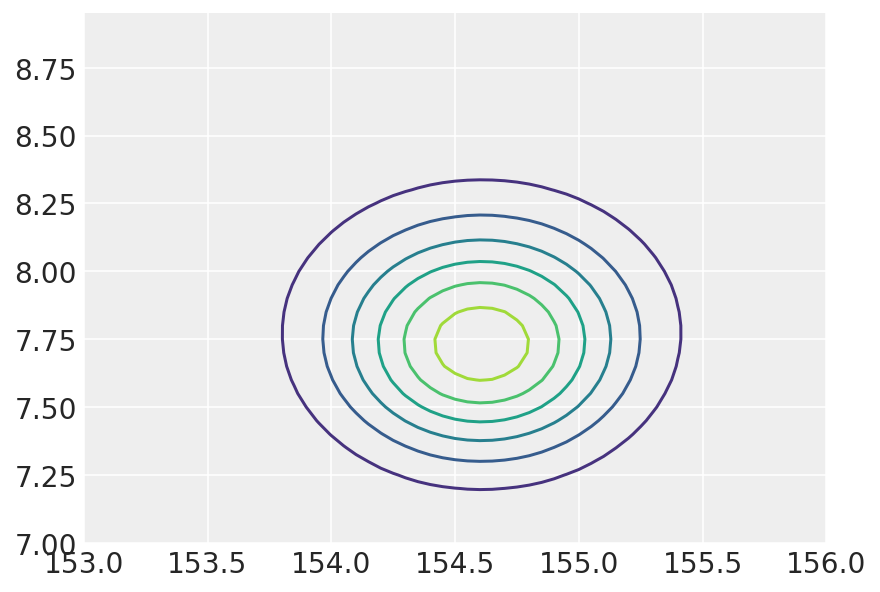

In [25]:
# regenerate the origial gird X and Y coordinates
X = np.arange(150, 160, 0.05)
Y = np.arange(7,9, 0.05)
plt.contour(X, Y, post_prob.reshape(200,-1).T)
plt.xlim(153, 156)


And here is the second.

(153.0, 156.0)

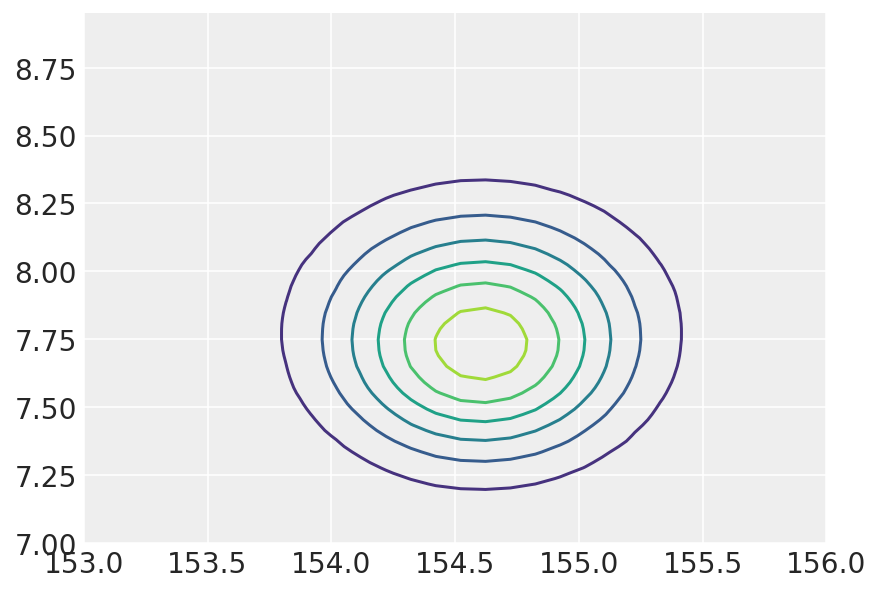

In [26]:
xi = np.linspace(post[:, 0].min(), post[:, 0].max(), 100)
yi = np.linspace(post[:, 1].min(), post[:, 1].max(), 100)
zi = griddata((post[:, 0], post[:, 1]), post_prob, (xi[None, :], yi[:, None]))

plt.contour(xi, yi, zi)
plt.xlim(153, 156)

#### Code 4.18

To create a simple "heatmap" we can (ab)use the [`matplotlib.pyplot.imshow()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html) function.

(153.0, 156.0)

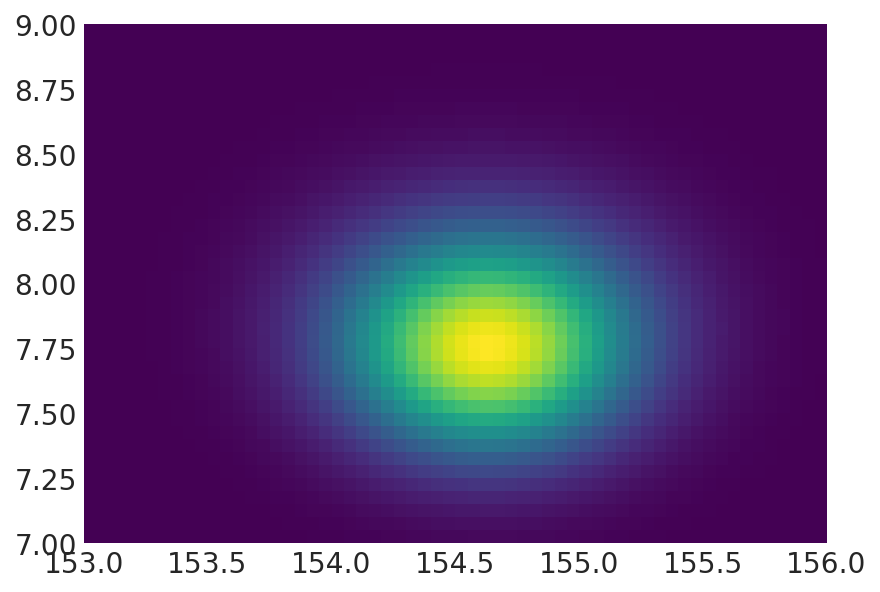

In [27]:
_, ax = plt.subplots()
# we could use the interpolated gid generated above to plot
#ax.imshow(zi, origin="lower", extent=[150.0, 160.0, 7.0, 9.0], aspect="auto")
# or  we could use the original grid and post_prob reshaped into a 2-D array 
ax.imshow(post_prob.reshape(200, -1).T, origin="lower", extent=[150, 160, 7, 9], aspect='auto')
ax.grid(False)
ax.set_xlim(153, 156)

#### Code 4.19 and 4.20

In [28]:
# turn the posterior relative probabilities into a probability distribution by normalizing
post_w = post_prob/sum(post_prob)

In [29]:
# let's store our data in a dataframe for easier manipulation, and to match better the
# strategy for data management in the R code in the text.
df = pd.DataFrame(post, columns=('mu', 'sigma'))
df['LL'] = likelihood
df['prod'] = post_prod
df['post'] = post_w

<a id="grid_search_dist"></a>

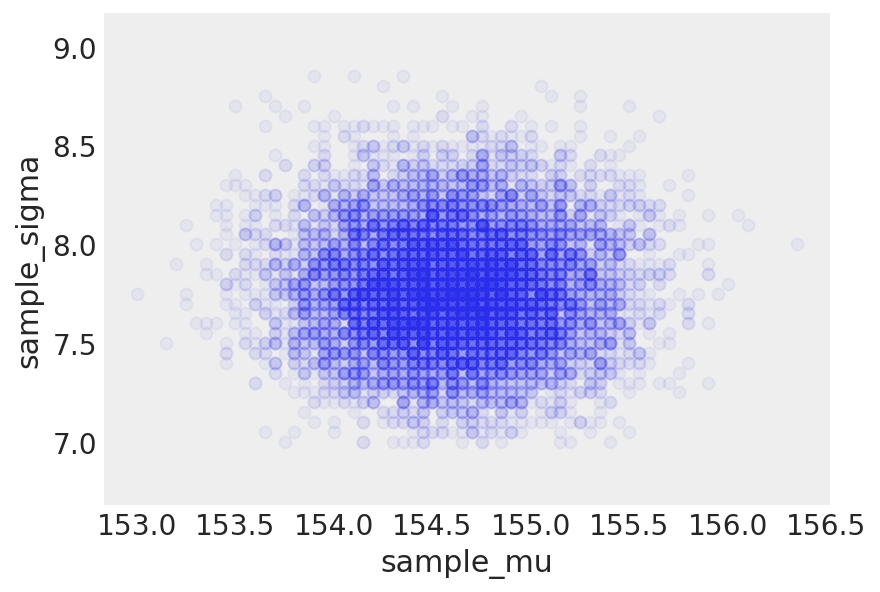

In [30]:
# choose 10000 indicies between 0, and len(post) with replacement
sample_rows = rng.choice(
    np.arange(len(post)), size=10000, replace=True, p=post_w
)
# use those indicies to generate the sample_mu and sample_sigma
sample_mu = df.mu[sample_rows]
sample_sigma = df.sigma[sample_rows]

plt.plot(sample_mu, sample_sigma, "o", alpha=0.05)
plt.axis("equal")
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma");

#### Code 4.21

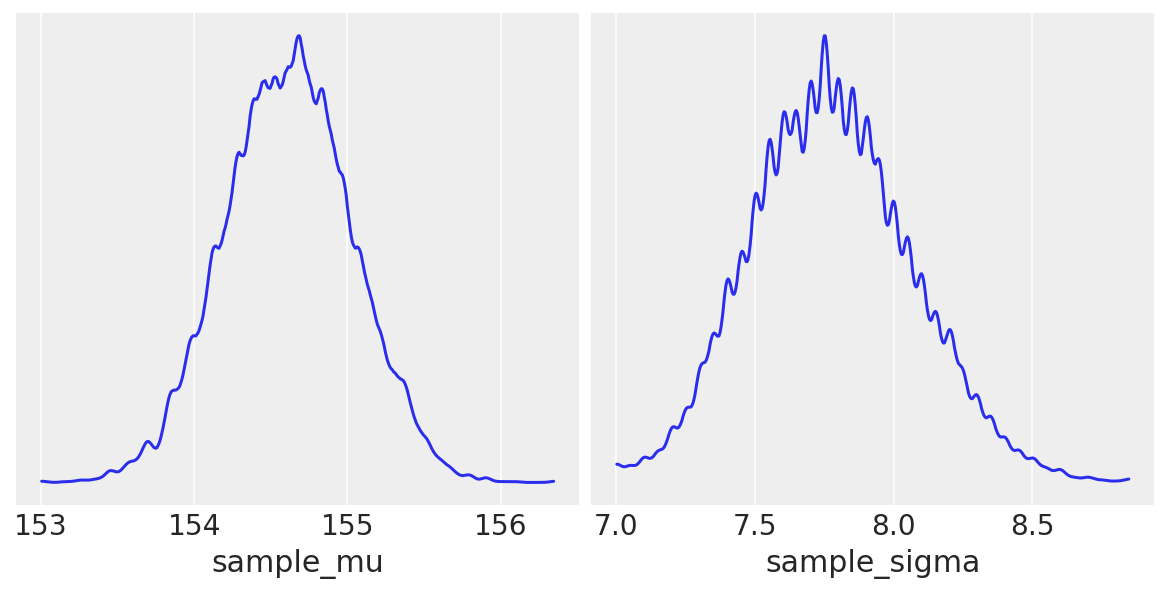

In [31]:
_, ax = plt.subplots(1, 2, figsize=(8, 4))
az.plot_kde(sample_mu.values, ax=ax[0])
ax[0].set_xlabel("sample_mu")
ax[0].set_yticks([])
az.plot_kde(sample_sigma.values, ax=ax[1])
ax[1].set_xlabel("sample_sigma")
ax[1].set_yticks([]);

#### Code 4.22

Highest density intervals at the default value defined in the [initialization](#initialArvizParams) cell of the workbook.

In [32]:
az.hdi(sample_mu.values), az.hdi(sample_sigma.values)

(array([153.9, 155.2]), array([7.3, 8.2]))

#### Code 4.23 and  4.24

In [33]:
# R code 4.23
d3 = rng.choice(d2.height, 20)

# R code 4.24
post2 = np.mgrid[150:170:0.1, 4:20:0.1].reshape(2, -1).T

likelihood2 = [
    sum(stats.norm.logpdf(d3, loc=post2[:, 0][i], scale=post2[:, 1][i])) for i in range(len(post2))
]

post_prod2 = (
    likelihood2
    + stats.norm.logpdf(post2[:, 0], loc=178, scale=20)
    + stats.uniform.logpdf(post2[:, 1], loc=0, scale=50)
)

post_prob2 = np.exp(post_prod2 - max(post_prod2))

sample_rows2 = rng.choice(
    np.arange(len(post2)), size=10000, replace=True, p=(post_prob2 / post_prob2.sum())
)
sample_mu2 = post2[:, 0][sample_rows2]
sample_sigma2 = post2[:, 1][sample_rows2]

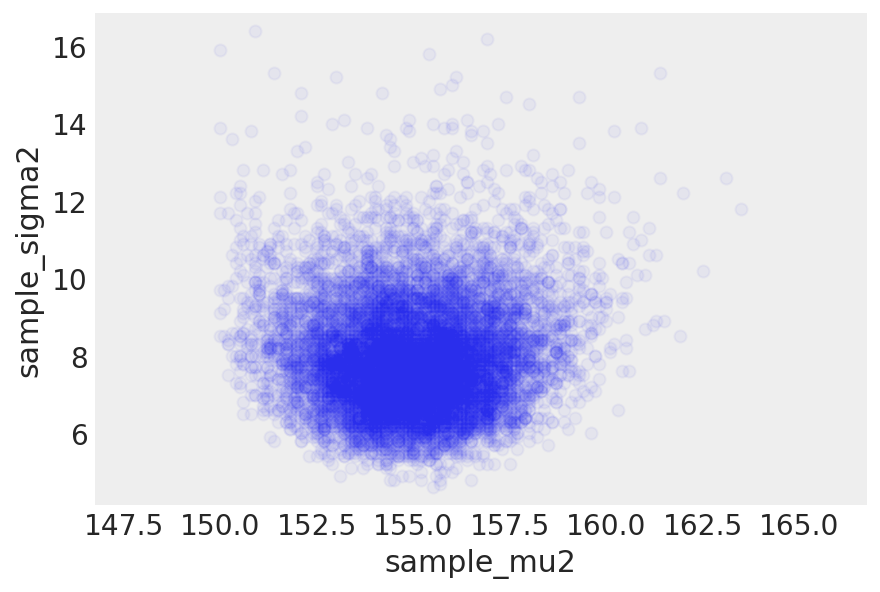

In [34]:
# The plotting code at the end of R code 4.24 
plt.plot(sample_mu2, sample_sigma2, "o", alpha=0.05)
plt.axis("equal")
plt.xlabel("sample_mu2")
plt.ylabel("sample_sigma2")
plt.grid(False);

#### Code 4.25

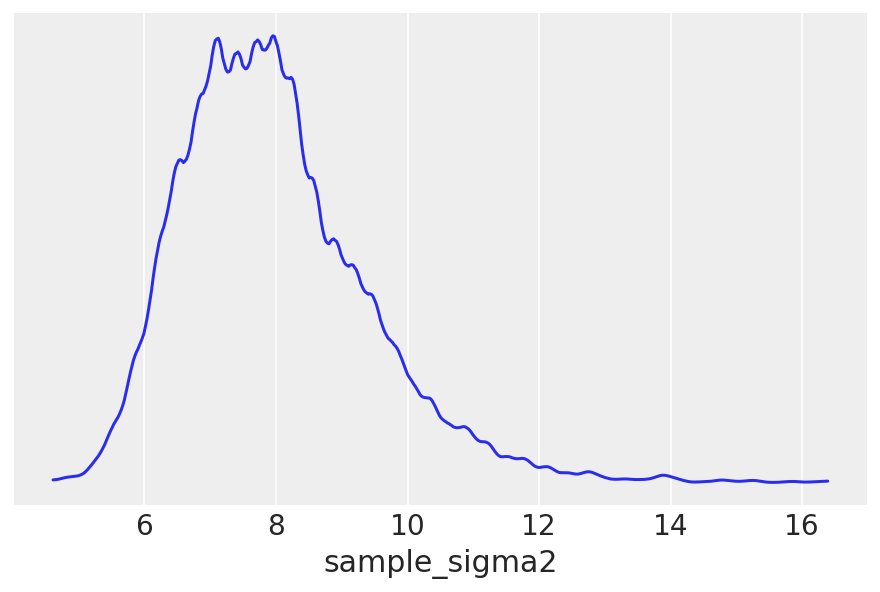

In [35]:
az.plot_kde(sample_sigma2)
plt.xlabel("sample_sigma2")
plt.yticks([]);

### 4.3.5. Finding the posterior distribution with `quap`.

#### Code 4.26

We are repeating code 4.7, 4.8 and 4.10

In [36]:
d = pd.read_csv("Data/Howell1.csv", sep=";", header=0)
d2 = d[d.age >= 18]

#### Code 4.27

There are multiple ways we can define our model in PyMC and they have the same result.  The compact way is to both declare a context and give it a name at the same time.  Then inside that context define the models varriables and data.  This is done using `with pm.Model() as m4_1:`

In [37]:
with pm.Model() as m4_1:
    # stochastic varriables mu and sigma
    mu = pm.Normal("mu", mu=178, sigma=20)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    # deterministic varraible height
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)

Alternativly you can declare the model container (for example `m4_1 = pm.Model()` and then open a context using that container `with m4_1`.

Note that the `height` varriable above is deterministic since the `observed=` option is set and has our exprimental data passed to it. 

#### Code 4.28

Recall that in Chapter 2 when we first used the quadratic approximation we first fit the model (using `pm.find_MAP()`) which generated a posterior distribution and then sampled from the resulting posterior. We could do that again here, but `PyMC` makes it simple to sample from the model using a "sampler method". Most common sampler methods are members of the Markov Chain Monte Carlo Method (MCMC) family (for details read Section 2.4.3 and Chapter 8 of Statistical Rethinking).

PyMC comes with various samplers. Some samplers are more suited than others for certain type of variable (and/or problems). For now we are going to let PyMC choose the sampler for us. PyMC also tries to provide a reasonable starting point for the simulation. By default PyMC uses the same adaptive procedure as in STAN `'jitter+adapt_diag'`, which starts with a identity mass matrix and then adapts a diagonal based on the variance of the tuning samples. 

The way you generate samples is to call the [`sample()`](https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.sample.html#pymc.sample) method in the context of the model we want to sample from as shown below.  The output of the sampling run is stored for later use.  The return type of a sampling run is an [Arviz](https://arviz-devs.github.io/arviz/index.html) [InferenceData](https://arviz-devs.github.io/arviz/schema/schema.html) object.

In [38]:
with m4_1:
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [39]:
trace_4_1['posterior'].dims

Frozen({'chain': 4, 'draw': 1000})

#### Code 4.29

For example we can get simple summary statistics from the sample as follows.

In [40]:
az.summary(trace_4_1, round_to=2, kind="stats")

mean    sd  hdi_5.5%  hdi_94.5%
mu     154.62  0.41    154.00     155.30
sigma    7.77  0.30      7.31       8.25

And we can plot the kernel density estimates as well as the values of the samples.  

array([[<AxesSubplot: title={'center': 'mu'}>,
        <AxesSubplot: title={'center': 'mu'}>],
       [<AxesSubplot: title={'center': 'sigma'}>,
        <AxesSubplot: title={'center': 'sigma'}>]], dtype=object)

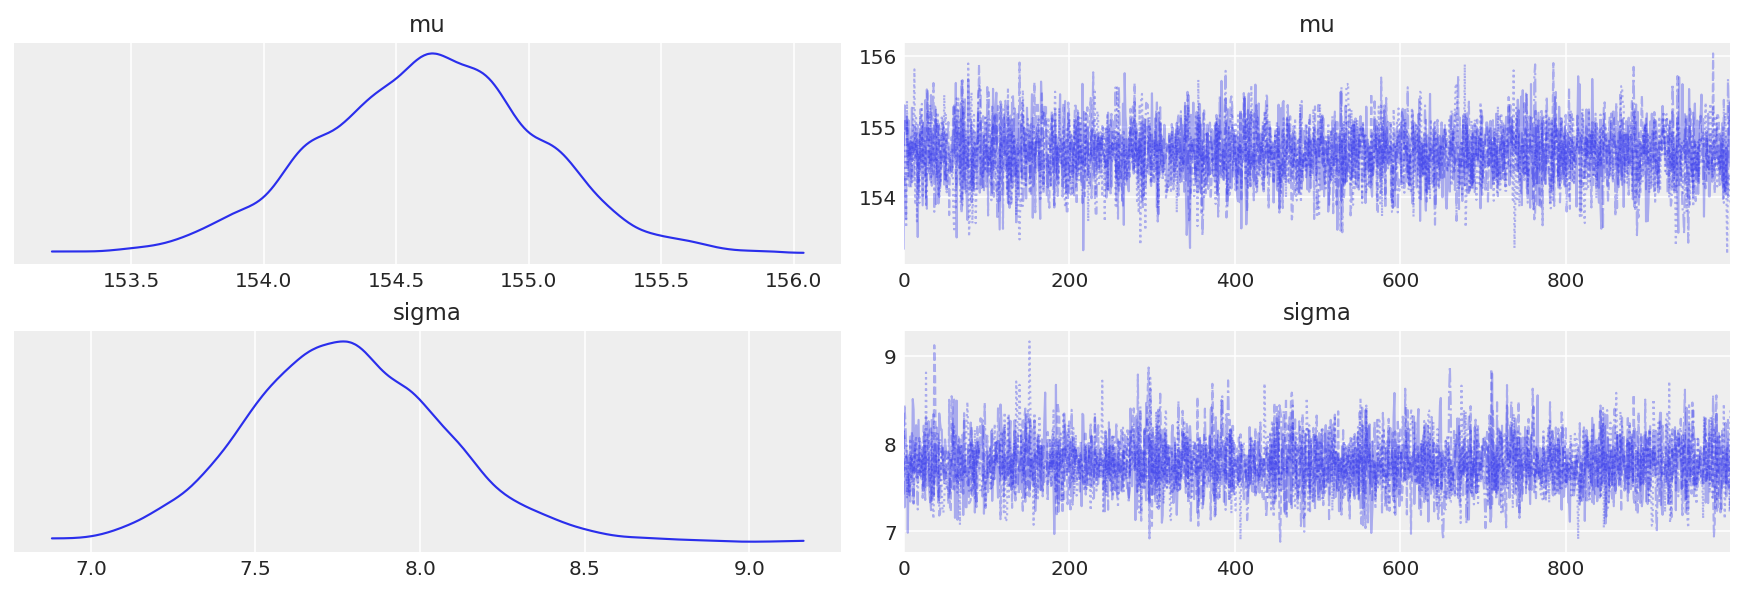

In [41]:
az.plot_trace(trace_4_1, combined=True)
# this function lets you check the samples values

#### Code 4.30

In PyMC we can provide initial values for the search by specifying the `initval` paramater to our prior distributions.  We do not have to as PyMC will look for reasonable choices automatically, but if you ever need to give it a hint on where to start, this is how you do it.

In [42]:
with pm.Model() as m4_1:
    mu = pm.Normal("mu", mu=178, sigma=20, initval=d2.height.mean())
    sigma = pm.Uniform("sigma", lower=0, upper=50, initval=d2.height.std())
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_1 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


#### Code 4.31

Using a stronger prior for sigma:

In [43]:
with pm.Model() as m4_2:
    mu = pm.Normal("mu", mu=178, sigma=0.1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_2 = pm.sample(1000, tune=1000)
az.summary(trace_4_2, round_to=2, kind="stats")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


mean    sd  hdi_5.5%  hdi_94.5%
mu     177.87  0.10    177.71     178.03
sigma   24.62  0.97     22.99      26.07

#### Code 4.32

Recall that the object returned as part of sampling is an [`InferenceData`](https://arviz-devs.github.io/arviz/schema/schema.html) object. The `InferenceData` object can be thought of as a container, and one of the things that it contains is the posterior samples.  To extract that posterior data to a `DataFrame` you can call the `arviz.trace_to_dataframe()` function.  And once you have the `DataFrame` you can use Pandas functions on it.

In [44]:
trace_df = az.extract_dataset(trace_4_1).to_dataframe()[['mu', 'sigma']]
trace_df.cov()

mu     sigma
mu     0.173831  0.003228
sigma  0.003228  0.087310

#### Code 4.33

Using `numpy.diag` makes an array out of the diagonal elements of a matrix (or dataframe) and taking the first two values of the resulting array gives us the varriances for $\mu$ and $\sigma$.

In [45]:
np.diag(trace_df.cov())

array([0.17383102, 0.08730984])

And to get the correlation matrix we do

In [46]:
trace_df.corr()

mu     sigma
mu     1.000000  0.026206
sigma  0.026206  1.000000

#### Code 4.34

We used a MCMC method to both condition our model and sample from the resulting posterior in one step. Recall the line of code:

    trace_4_1 = pm.sample(1000, tune=1000)

in our `pm.Model()` [above](#sampling).

Thus, we already have samples. We can do something like this to reset the index and ignore the `chain` and `draw` indicies.

In [47]:
trace_df.reset_index(level=[0,1])[['mu','sigma']].head()

mu     sigma
0  154.179519  7.825758
1  154.330064  7.722300
2  154.640940  7.599712
3  154.986248  7.897407
4  155.359234  7.776014

Or we can get values directly from the trace (we are getting the first ten samples of _sigma_)

In [48]:
trace_4_1.posterior["sigma"][0][:10].values

array([7.82575825, 7.72230036, 7.59971174, 7.89740653, 7.77601391,
       7.77601391, 7.49989203, 7.60837283, 7.6083338 , 7.67820136])

If we needed more samples, or new samples we just re-run the `pm.Sample()` with new options.

In [49]:
trace_4_1 = pm.sample(int(1e4), model=m4_1, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [mu, sigma]


Sampling 1 chain for 1_000 tune and 10_000 draw iterations (1_000 + 10_000 draws total) took 10 seconds.


In [50]:
trace_df = az.extract_dataset(trace_4_1).to_dataframe()[['mu', 'sigma']]

In [51]:
post = trace_df.reset_index(level=[0,1])[['mu','sigma']]
print(post.shape)
post.head()

(10000, 2)


mu     sigma
0  154.565966  7.615094
1  154.565966  7.615094
2  154.565966  7.615094
3  154.293851  7.921430
4  154.810101  7.330956

#### Code 4.35

In our case, this is the same we did in the code 4.27

In [52]:
az.summary(trace_4_1, round_to=2, kind="stats")

mean    sd  hdi_5.5%  hdi_94.5%
mu     154.60  0.42    153.92     155.25
sigma    7.78  0.30      7.33       8.28

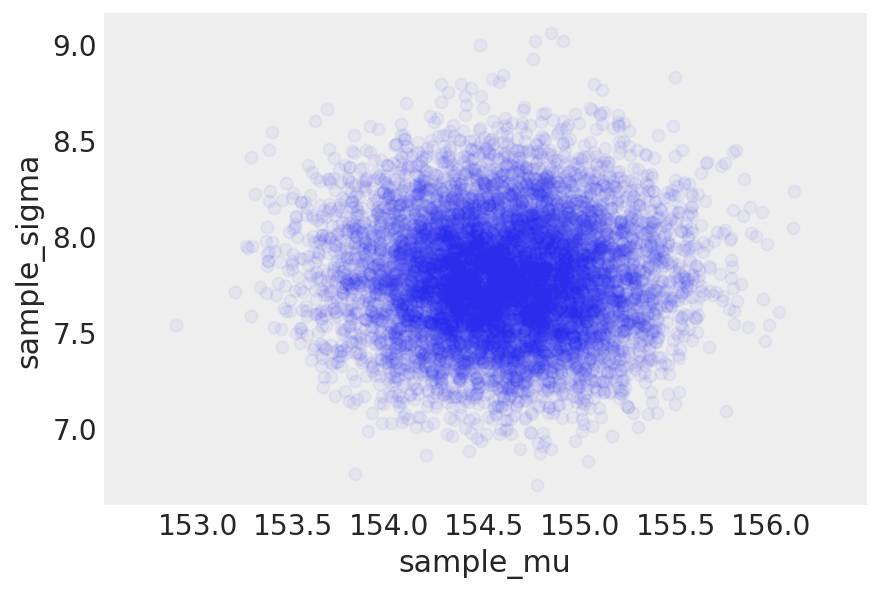

In [53]:
plt.plot(trace_4_1.posterior["mu"]['draw'==10], trace_4_1.posterior["sigma"]['draw'==10], "o", alpha=0.05)
plt.axis("equal")
plt.grid(False)
plt.xlabel("sample_mu")
plt.ylabel("sample_sigma");

And we can compare it to the [grid search](#grid_search_dist) version that we found previously.

#### Code 4.36

Note that since we are not actually using `quap` here, but we are using a MCMC sampler, the following is _not_ what is doing the sampling we did above.  Since `quap` is using a Gausian distribution as an approximation of our models distribution, this is what would be used to generate samples from the posterior, since that posterior is modeled by the Gausian distribution.

In [54]:
stats.multivariate_normal.rvs(mean=trace_df.mean(), cov=trace_df.cov(), size=10)

array([[153.98178406,   7.83064484],
       [155.43635685,   8.40839182],
       [154.81468155,   8.15839329],
       [154.78044475,   7.39167421],
       [155.24129026,   7.95697555],
       [155.05924404,   8.19183121],
       [154.20842188,   7.72726619],
       [154.07514657,   7.06122631],
       [154.11813513,   7.46524173],
       [155.47804326,   7.97770308]])

## 4.4 Linear prediction

#### Code 4.37

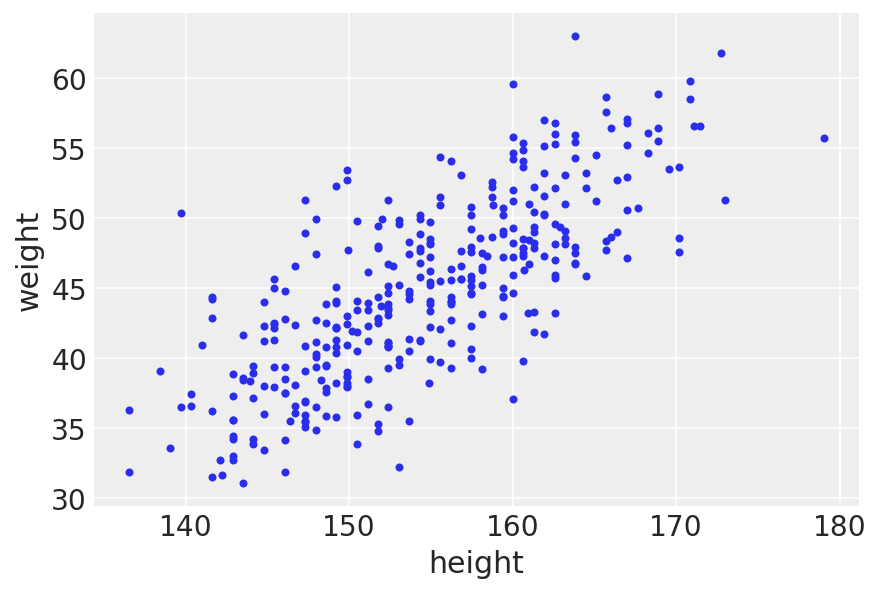

In [55]:
plt.plot(d2.height, d2.weight, ".")
plt.xlabel("height")
plt.ylabel("weight");

#### Code 4.38

With the goal of simulating our Prior Predictive distribution, lets generate some data.  We will take 100 valules of the paramaters $\alpha$ and $\beta$.  Recal that our priors have both $\alpha$ and $\beta$ come from normal distributions.

In [56]:
height_rng = np.random.default_rng(2971)

N = 100  # 100 lines
a = stats.norm.rvs(178, 20, N)
b = stats.norm.rvs(0, 10, N)

#### Code 4.39, 4.40 and 4.41

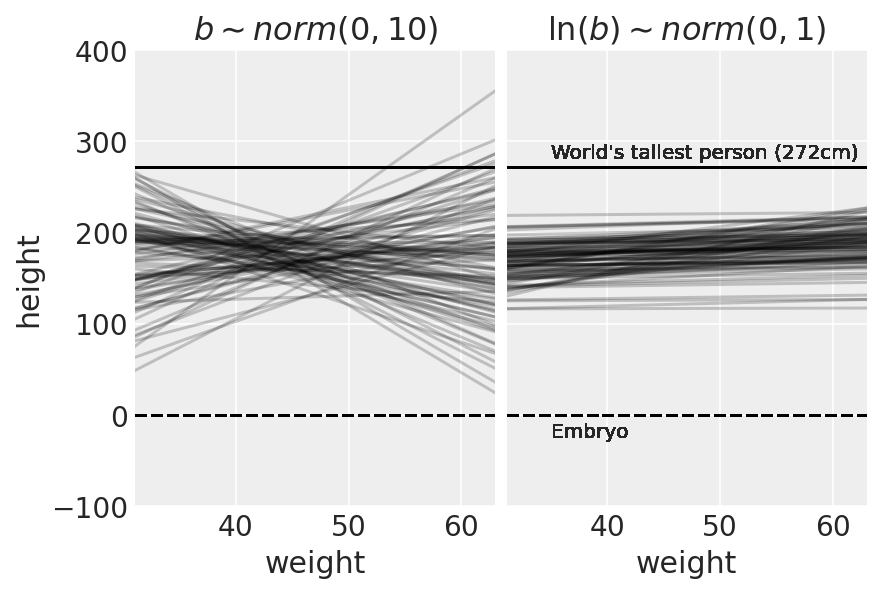

In [57]:
_, ax = plt.subplots(1, 2, sharey=True)
xbar = d2.weight.mean()
x = np.linspace(d2.weight.min(), d2.weight.max(), N)
for i in range(N):
    ax[0].plot(a[i] + b[i] * (x - xbar), "k", alpha=0.2)
    ax[0].set_xlim(d2.weight.min(), d2.weight.max())
    ax[0].set_ylim(-100, 400)
    ax[0].axhline(0, c="k", ls="--")
    ax[0].axhline(272, c="k")
    ax[0].set_title("$b\sim norm(0,10)$")
    ax[0].set_xlabel("weight")
    ax[0].set_ylabel("height")
# for Code 4.40 we redefine our prior to be the log-normal distribution
# This implies that we are postulating the prior knowlege that
# average height increases as average weight increases.  If that is not 
# borne out in the data we will find out when we condiditon the model on
# the data.
b2 = stats.lognorm.rvs(s=1, scale=1, size=100)
for i in range(N):
    ax[1].plot(a[i] + b2[i] * (x - xbar), "k", alpha=0.2)
    ax[1].set_xlim(d2.weight.min(), d2.weight.max())
    ax[1].set_ylim(-100, 400)
    ax[1].axhline(0, c="k", ls="--", label="embryo")
    ax[1].axhline(272, c="k")
    ax[1].set_title("$\ln(b)\sim norm(0,1)$")
    ax[1].set_xlabel("weight")
    ax[1].text(x=35, y=282, s="World's tallest person (272cm)")
    ax[1].text(x=35, y=-25, s="Embryo");

#### Code 4.42

<a id="trace_4_3"></a>

In [59]:
with pm.Model() as m4_3:
    a = pm.Normal("a", mu=178, sigma=20)
    # here we define a log-normal distribution on beta
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    # and use beta directly in our linear model.
    mu = a + b * (d2.weight.values - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_3 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


#### Code 4.43 

Here is the same model but using a normaly distributed paramater `log_b`, rather than a log-normal distributed `b`.

In [60]:
with pm.Model() as m4_3b:
    a = pm.Normal("a", mu=178, sigma=20)
    # here we define the paramater beta to be normal
    log_b = pm.Normal("log_b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    # and our linear model now takes the exponential to effect a log-normal distribuiont in beta
    mu = a + np.exp(log_b) * (d2.weight.values - xbar)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d2.height.values)
    trace_4_3b = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, log_b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


#### Code 4.44

In [61]:
az.summary(trace_4_3, kind="stats")

mean     sd  hdi_5.5%  hdi_94.5%
a      154.603  0.276   154.155    155.038
b        0.904  0.043     0.839      0.975
sigma    5.105  0.196     4.802      5.418

#### Code 4.45

In [62]:
trace_4_3_df = trace_4_3.posterior.to_dataframe()
trace_4_3_df.cov().round(3)

a      b  sigma
a      0.076 -0.000  0.001
b     -0.000  0.002 -0.000
sigma  0.001 -0.000  0.038

While this code snippet does not get a code label in the text, it is worth noting that there is a similar function available in Arviz, [`arviz.plot_pair()`](https://arviz-devs.github.io/arviz/api/generated/arviz.plot_pair.html).

array([[<AxesSubplot: ylabel='a'>, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: ylabel='b'>, <AxesSubplot: >, <AxesSubplot: >],
       [<AxesSubplot: xlabel='a', ylabel='sigma'>,
        <AxesSubplot: xlabel='b'>, <AxesSubplot: xlabel='sigma'>]],
      dtype=object)

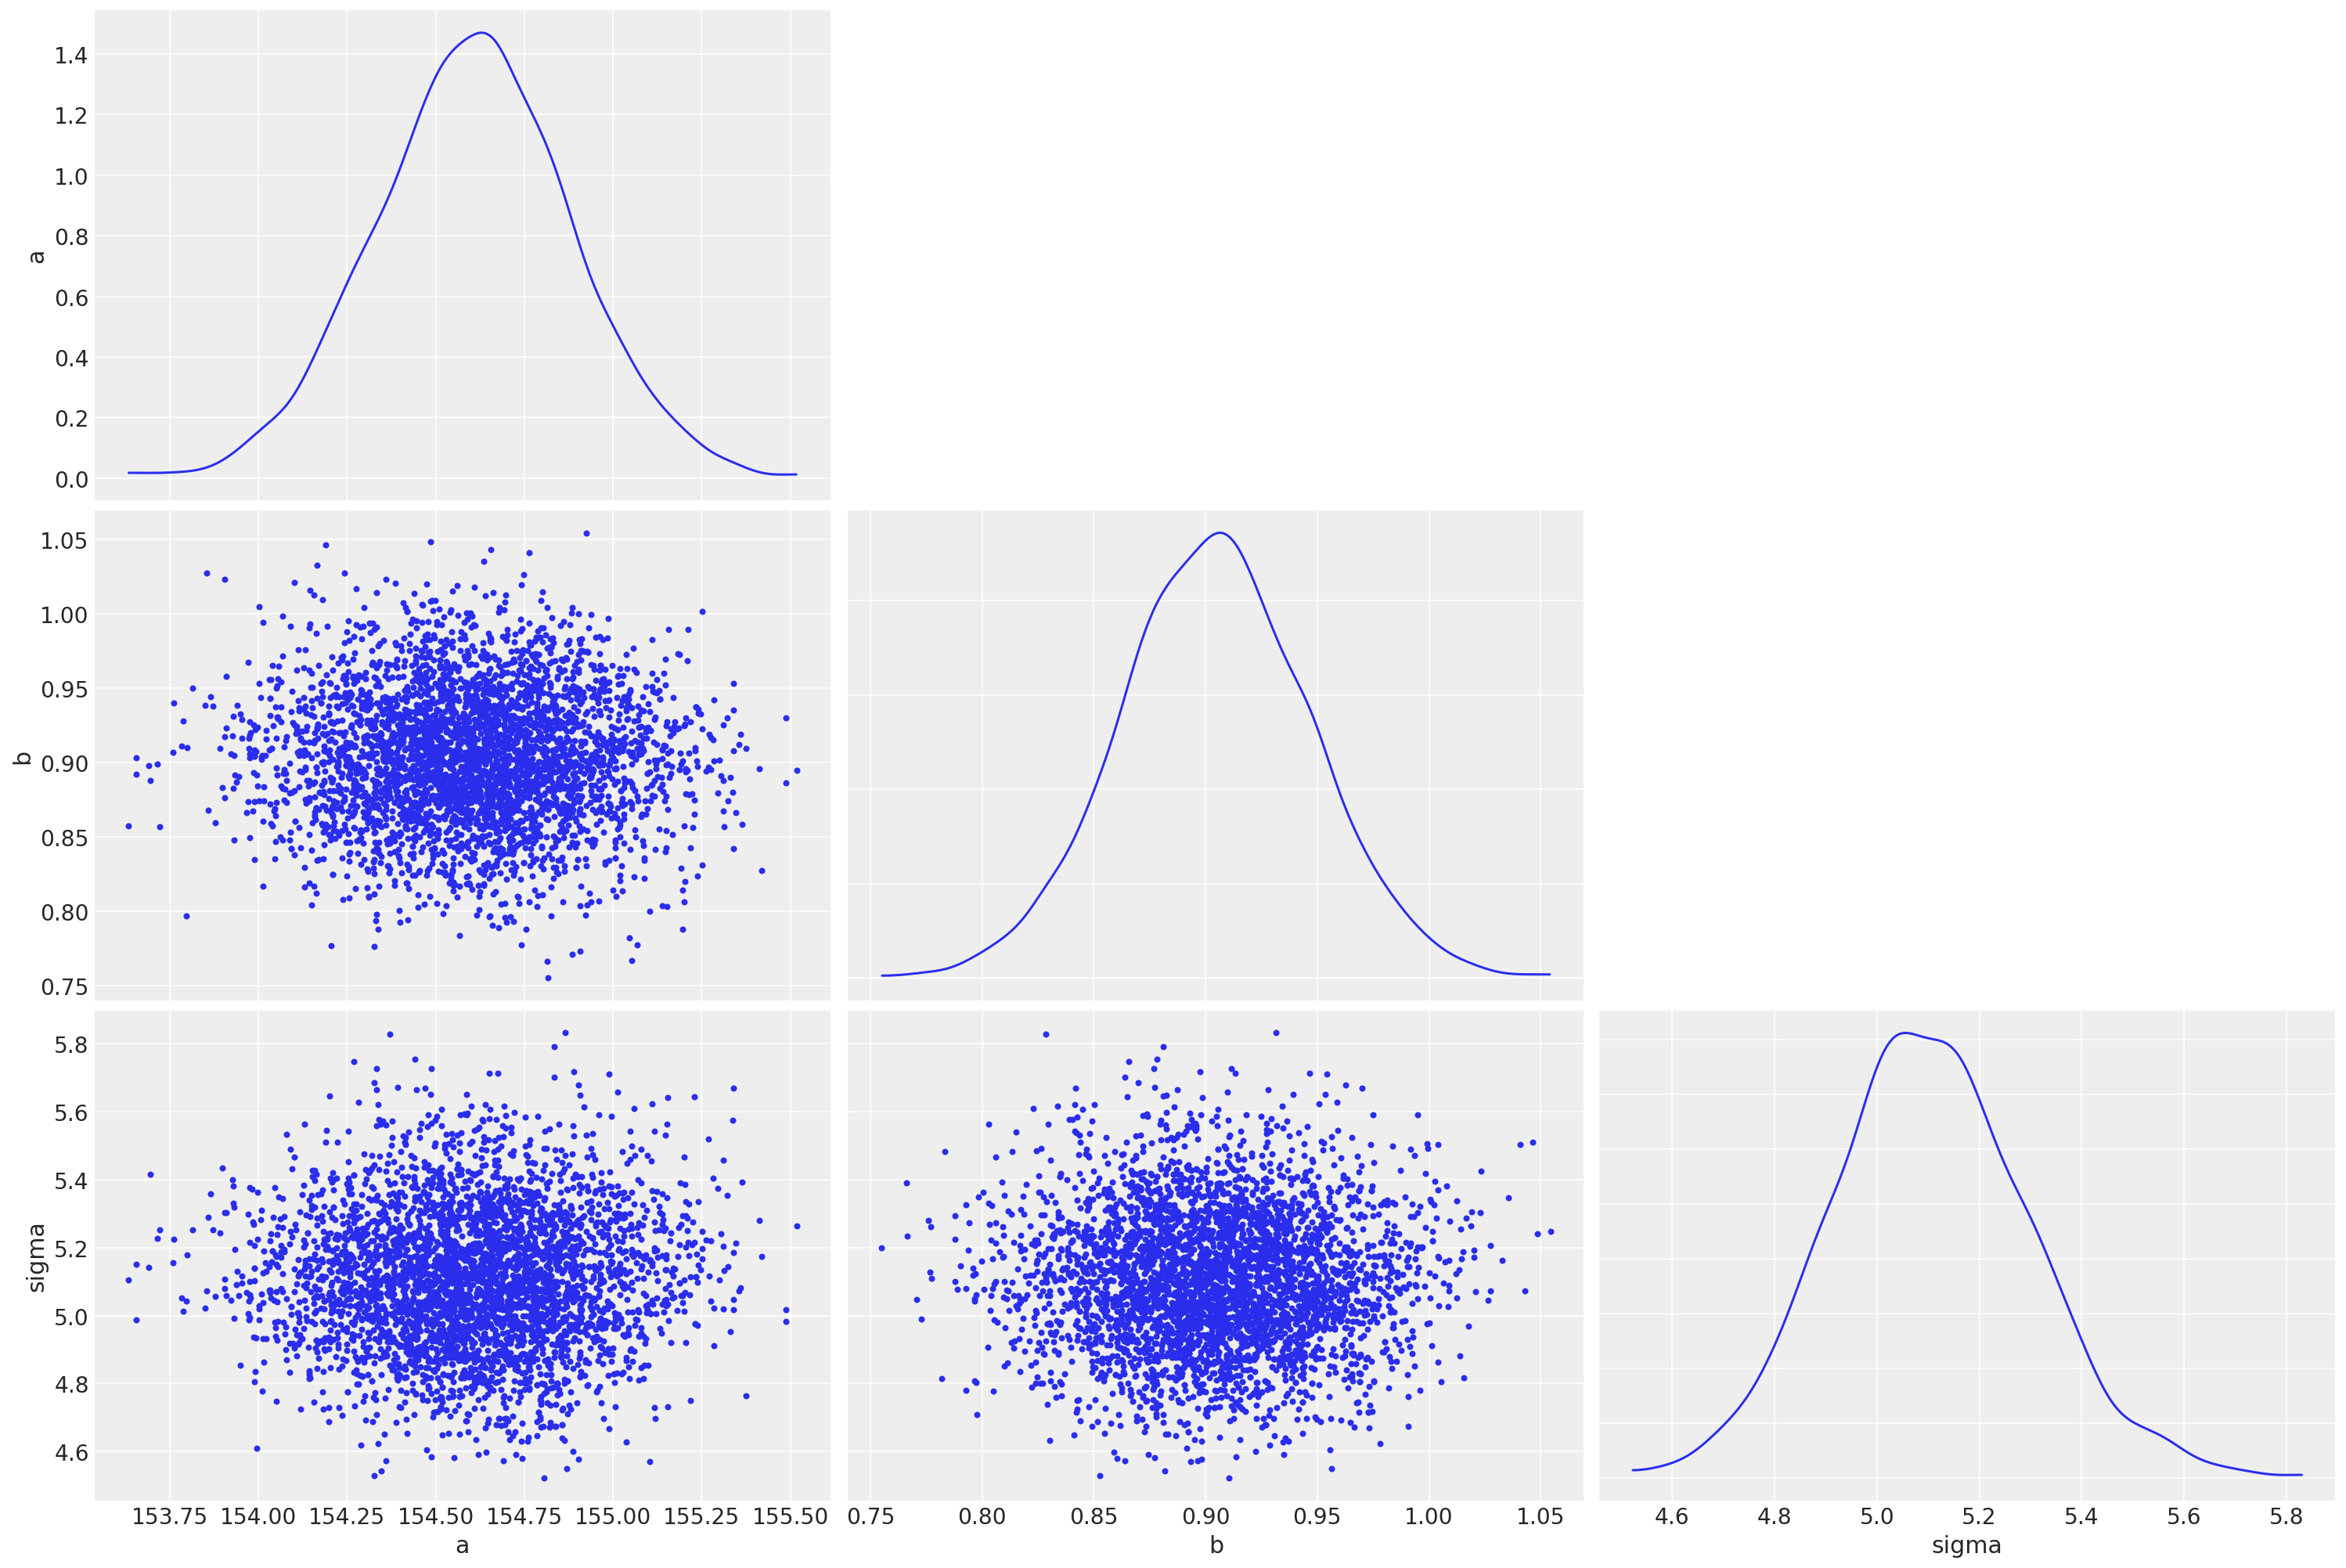

In [63]:
az.plot_pair(trace_4_3, marginals=True)

#### Code 4.46

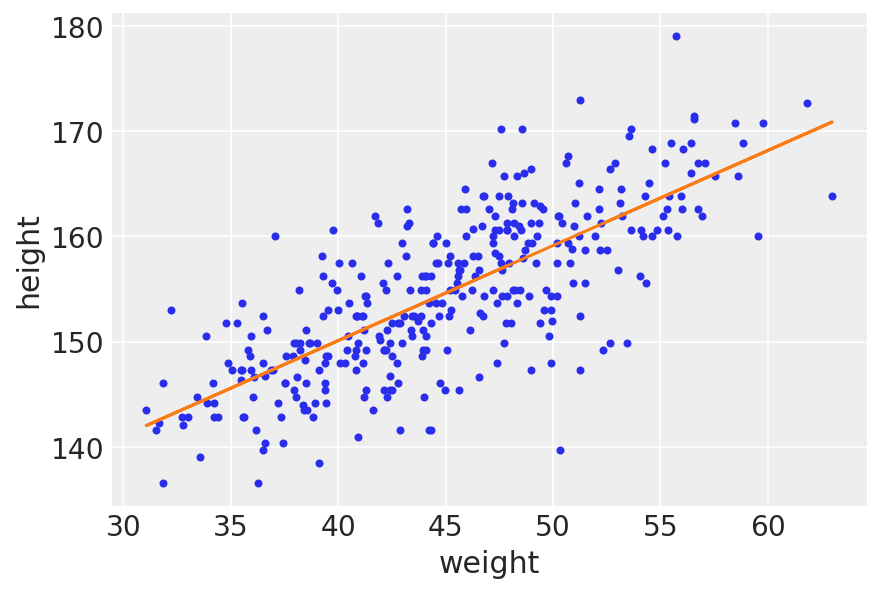

In [64]:
# plot wieght vs height
plt.plot(d2.weight, d2.height, ".")
# plot the most likely line.
plt.plot(
    d2.weight,
    # the mean value for our paramater 'a', the intercept
    trace_4_3.posterior["a"].mean().item(0)
    # the mean value for our paramater 'b', the slope, times the deviation from the mean weight
    + trace_4_3.posterior["b"].mean().item(0) * (d2.weight - xbar),
)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

#### Code 4.47

Note that in PyMC we get additional data about our samples. In particular, depending on the number of cores are available on the computer used to run this code, you will get a number of different sampling runs.  And for each of those runs you will get a collection of sample data.  So you will see two additional columns, `chain` and `draw`.

In [65]:
trace_4_3_df.head()

a         b     sigma
chain draw                                
0     0     154.839661  0.932331  5.299400
      1     154.964165  0.964926  5.094785
      2     154.964165  0.964926  5.094785
      3     154.255420  0.833549  5.250069
      4     154.336524  0.860809  5.276123

#### Code 4.48
<a id="mu_deterministic"></a>

In [66]:
# N is now a list of the sizes of samples we are going to use
# we start with the first value, 10.  The syntax here is silly
# but we will be re-using this code later to re-do this over
# all four values, and not just the first value.
N = [10, 50, 150, 352][0]
# select the first 10 values of our data.
dN = d2[:N]
# take the mean weight of our samples
w_bar = dN.weight.mean()
# we train the model on the subset of the data.
with pm.Model() as m_N:
    a = pm.Normal("a", mu=178, sigma=100)
    b = pm.Lognormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", 0, 50)
    # here we provide information to our model that mu is a deterministic varriable
    # we want to be able to sample from values of mu, so we tell the model to keep
    # information about mu as it relates to the data points
    mu = pm.Deterministic("mu", a + b * (dN.weight.values - w_bar))
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=dN.height.values)
    # we depart a bit from the text here.  In the text they take only 20 samples from 
    # the posterior.  Here we are going to take more and select only 20 of those samples
    # to plot.
    chain_N = pm.sample(1000, tune=1000)

trace_N = az.extract_dataset(chain_N)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


#### Code 4.49

If we now take a sample of 10 pairs from the posterior distribution of our model and plot those lines with the actual data used as a background.  The trace_N object is an [xarray](https://docs.xarray.dev/en/stable/index.html) object and it is an extension of the idea of a pandas DataFrame and NumPy arrays.

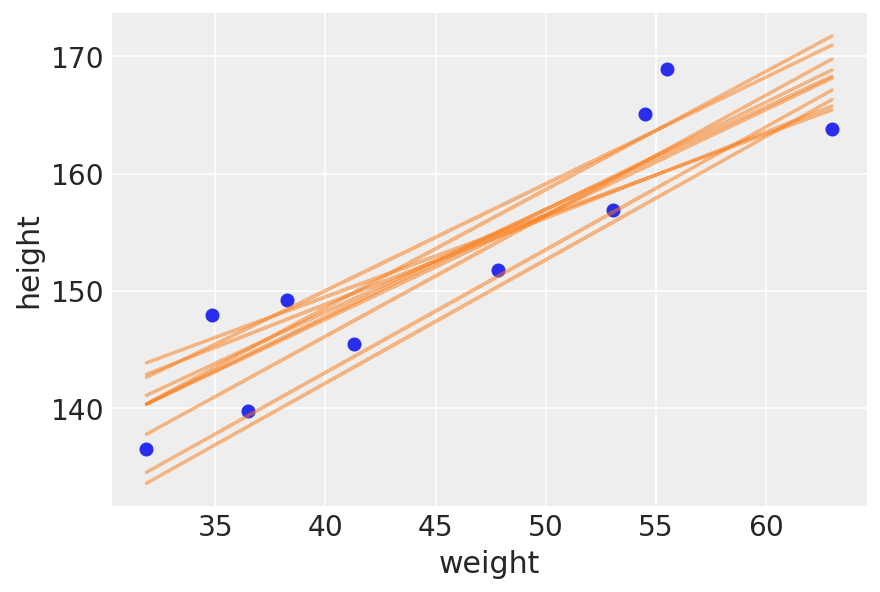

In [67]:
# plot our experimental data, the first 10 entries in this case
plt.plot(dN.weight, dN.height, "C0o")
# the total number of samples we have to chose from
nb_samples = trace_N.sizes["sample"]
# generate 20 random indicies
idxs = height_rng.integers(nb_samples, size=10)
for idx in idxs:
    # for each of the 20 random indicies plot a line where:
    # the intercept is given by the `a` paramater for that index
    # the slope is given by the `b` paramater
    plt.plot(
        dN.weight,
        trace_N["a"].item(idx) + trace_N["b"].item(idx) * (dN.weight - dN.weight.mean()),
        "C1-",
        alpha=0.5,
    )
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

Alternative we can directly use the deterministic `mu = pm.Deterministic()` variable that we saved in our model [above](#mu_deterministic).

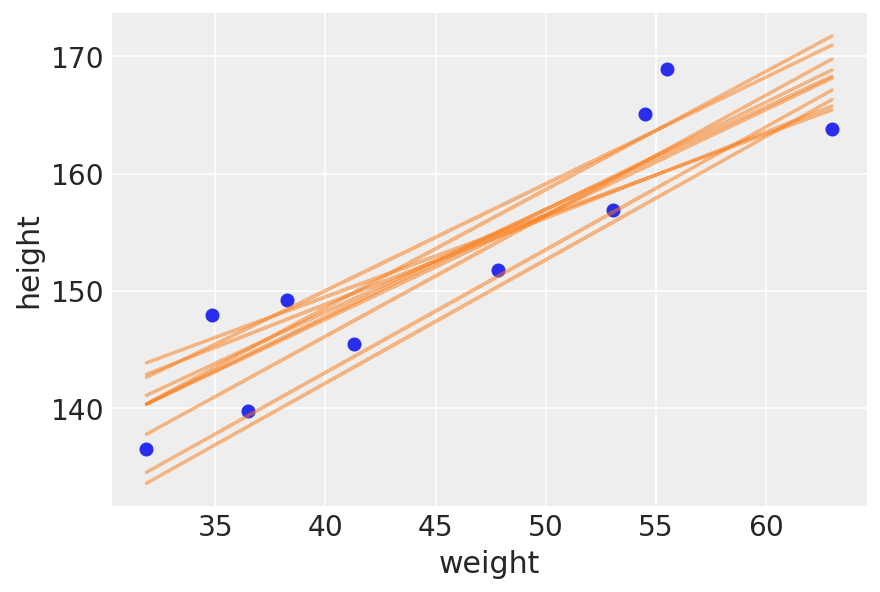

In [68]:
plt.plot(dN.weight, dN.height, "C0o")
for idx in idxs:
    plt.plot(d2.weight[:N], trace_N["mu"][:, idx], "C1-", alpha=0.5)
plt.xlabel(d2.columns[1])
plt.ylabel(d2.columns[0]);

Storing information about `mu` makes it easier to script the diagrams below.  The text asks us to re-do the above, but with increasingly large subsets of the source data.

In [69]:
# create models for these data sizes
N = [10, 50, 150, 352]

data = []
traces = []
for n in N:
    # m_N will be a model fit with the first N entries from our >18 height/weight data
    dN = d2[:n]
    with pm.Model() as m_N:
        a = pm.Normal("a", mu=178, sigma=100)
        b = pm.Lognormal("b", mu=0, sigma=1)
        sigma = pm.Uniform("sigma", 0, 50)
        # for each of our data points store the corresponding `mu` based on the `a` and `b` 
        mu = pm.Deterministic("mu", a + b * (dN.weight.values - dN.weight.mean()))
        height = pm.Normal("height", mu=mu, sigma=sigma, observed=dN.height.values)
        # store the InferenceData from our fit model
        traces.append(pm.sample(1000, tune=1000, progressbar=False))
        # store the data used to fit the model
        data.append(dN)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


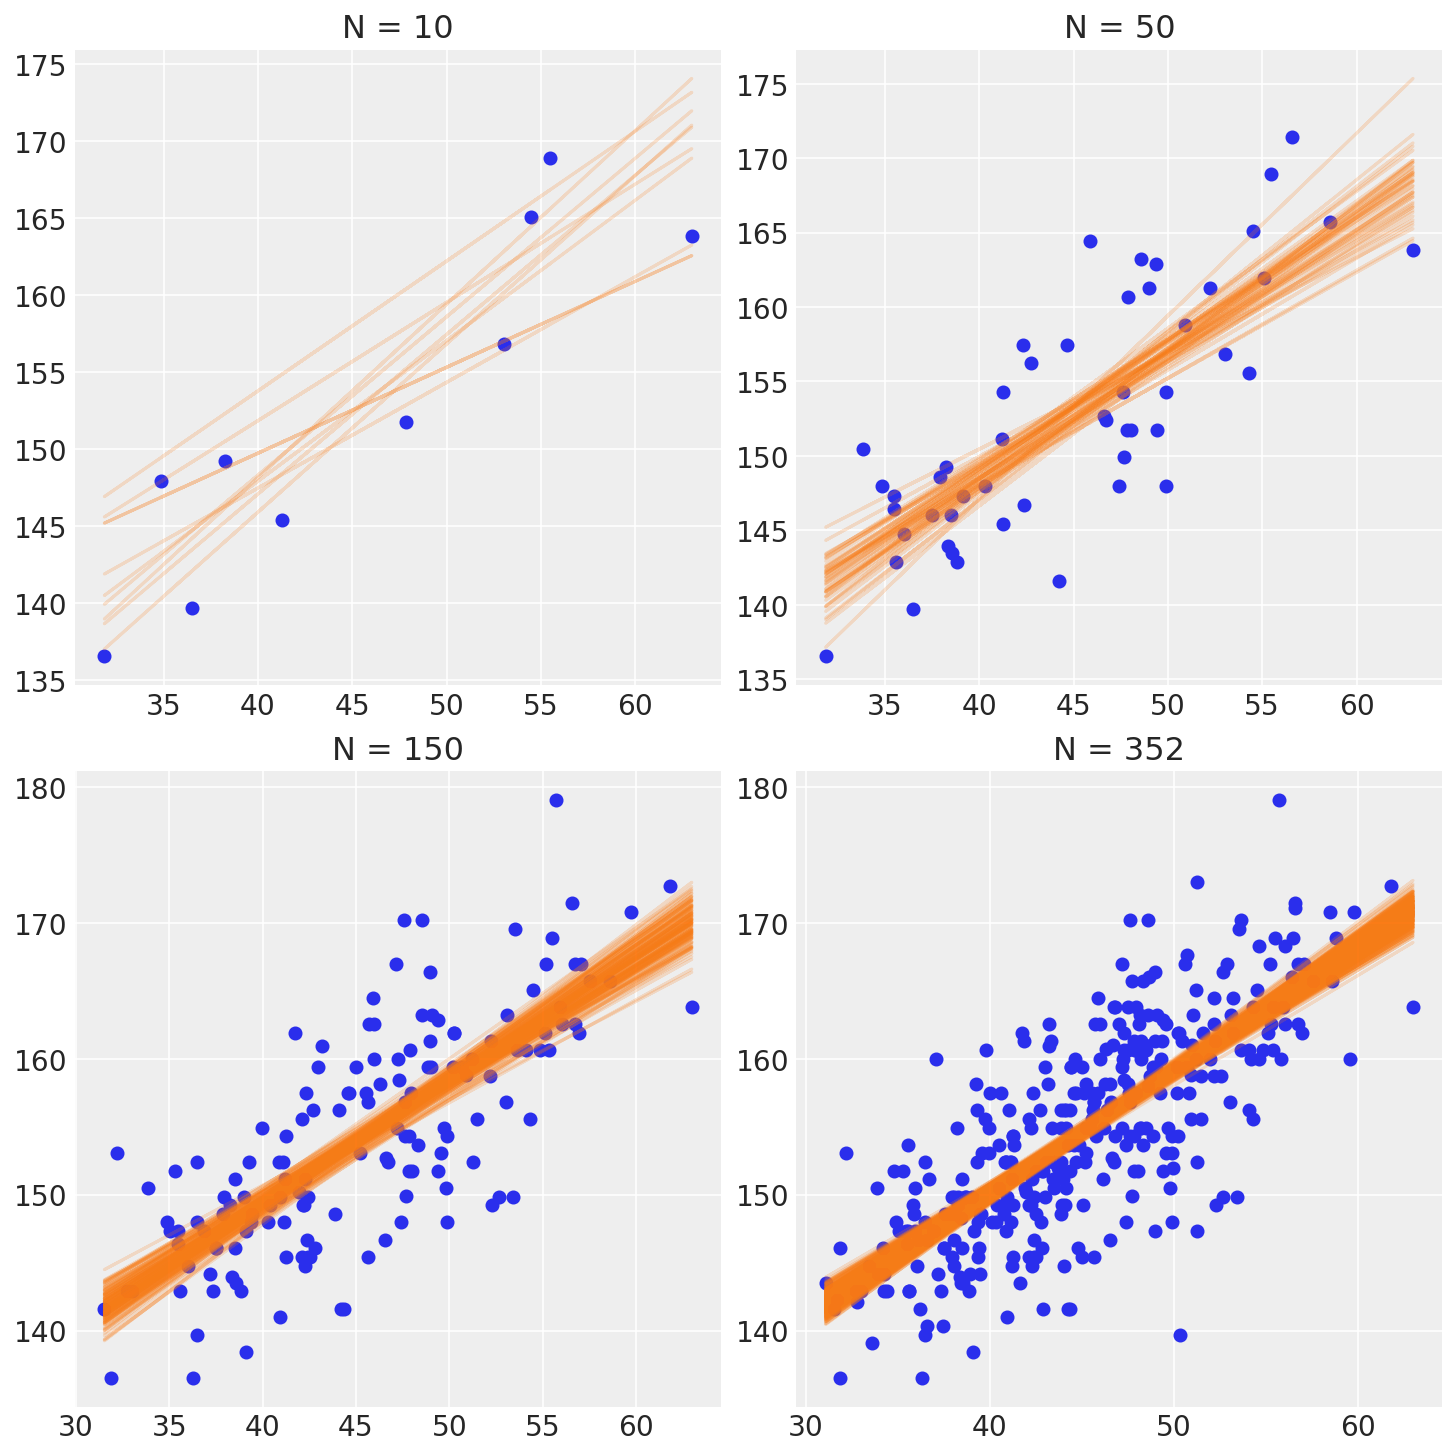

In [70]:
# four plots in two rows
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
# a list of the plots in the order we want them
cords = [(0, 0), (0, 1), (1, 0), (1, 1)]
for i in range(len(data)):
    # generate some random indicies of lenght N[i]
    idxs = height_rng.integers(nb_samples, size=N[i])
    # plot the data that was used to fit the model
    ax[cords[i]].plot(data[i].weight, data[i].height, "C0o")
    # for each of our random samples from our posterior plot the line associated with that sample
    ax[cords[i]].set_title(f'N = {len(data[i])}')
    for idx in idxs:
        ax[cords[i]].plot(
            data[i].weight, az.extract_dataset(traces[i])["mu"][:, idx], "C1-", alpha=0.2
        )

#### Code 4.50

Lets go back to the model fit with the full dataset.  Recall that the varriable [`trace_4_3`](#trace_4_3) held that data.  Then we can look at the uncertainty about the regression line when the weight of an individual is 50Kg which we might label $\mu\mid_{w=50}$

In [71]:
# arviz.extract_dataset to get the posterior data out of our InferenceData object.
data_4_3 = az.extract_dataset(trace_4_3)
mu_at_50 = data_4_3["a"] + data_4_3["b"] * (50 - d2.weight.mean())

#### Code 4.51

And we can plot a kernel density estimate for this distribution.

Text(0.5, 1.0, 'Kernel Density Estimate\n of mean height $\\mu\\mid _{w=50}$')

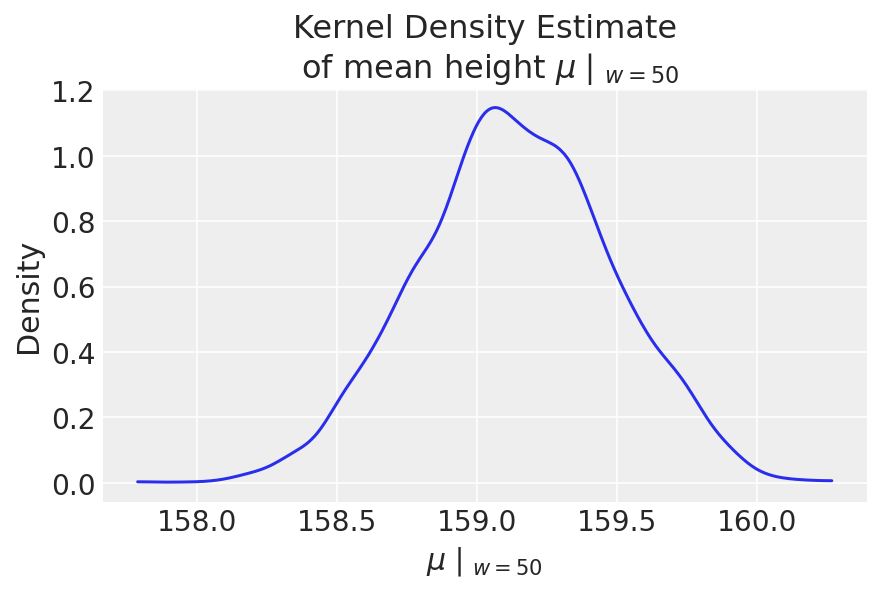

In [72]:
az.plot_kde( mu_at_50.values)
plt.xlabel("$\mu\mid_{w=50}$")
#plt.yticks([]);
plt.ylabel("Density")
plt.title("Kernel Density Estimate\n of mean height $\mu\mid _{w=50}$")

#### Code 4.

As well as look at the compatiblity intervals.

In [73]:
az.hdi(mu_at_50.values, hdi_prod=0.89)

array([158.59117708, 159.71518908])

But that is at just one point, $\mu = 50$.  For any weight that we choose there will be a different distribution paramaterized by the mean. To visualize this we need to draw comaptibility intervals around the average slope.

#### Code 4.53 and 4.54

PyMC provides some tools to accomplish this, but we will do this _manually_ to show what the book is doing by using the ```link``` function ( and is shown in the `R code 4.58` Overthinking: How `link` works box). The [`xarray.isel()`](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.isel.html) function allows us to select slices of our `InferenceData` object.

In [74]:
# define a range of weights. We will be plotting uncertainty about the mean for each of these weights
# note that these weights might not be in our data.  We are simulating our data here.
weight_seq = np.arange(25, 71)
# How many samples do we have?
nb_samples = trace_4_3.posterior.dims['chain'] *  trace_4_3.posterior.dims['draw']
# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
# for example we can use every tenth sample
trace_4_3_thinned = data_4_3.isel(sample=range(0, nb_samples, 10))
nb_samples_thinned = trace_4_3_thinned.sizes["sample"]
# define an array to store our data in.  This will be a matrix with each row being the samples from 
# the posterior for mu
mu_pred = np.zeros((len(weight_seq), nb_samples_thinned))
# for each weight that we are interested in
for i, w in enumerate(weight_seq):
    # compute mu's for all thinned sample of 'a' and 'b' values at the current weight
    # and store them in our array
    mu_pred[i] = trace_4_3_thinned["a"] + trace_4_3_thinned["b"] * (w - d2.weight.mean())

#### Code 4.55

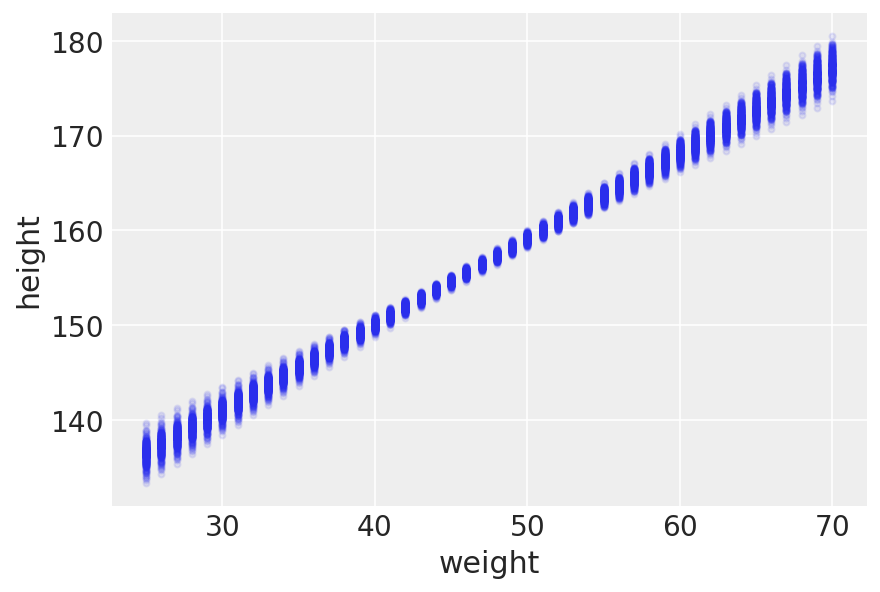

In [75]:
plt.plot(weight_seq, mu_pred, "C0.", alpha=0.1)
plt.xlabel("weight")
plt.ylabel("height");

In [76]:
mu_pred.shape

(46, 400)

So now `mu_pred` is a matrix where each row is a sample of 400 values from our posterior where the weight is fixed and distributed according to our model.

#### Code 4.56

In [77]:
# extract the mean value of mu for each of our weights
mu_mean = mu_pred.mean(1)
# compute the highest density interval of mu for each weight
mu_hdi = az.hdi(mu_pred.T)

/tmp/ipykernel_360967/1458299839.py:4: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  mu_hdi = az.hdi(mu_pred.T)


#### Code 4.57

/home/guy/Applications/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


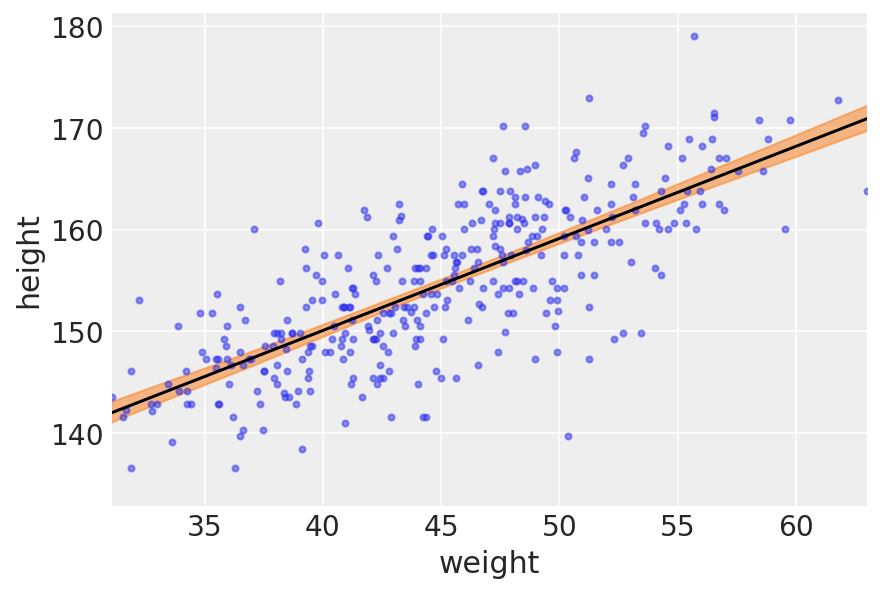

In [78]:
# plot the HDI
az.plot_hdi(weight_seq, mu_pred.T)
plt.scatter(d2.weight, d2.height, marker='.', alpha=0.5)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.58

#### Code 4.59

So we have displayed our uncertainty about $\mu$, the mean predicted height.  Lets now represent our uncertainty about $\sigma$.  We are going to use [`pymc.sample_posterior_predictive()`](https://www.pymc.io/projects/docs/en/latest/api/generated/pymc.sample_posterior_predictive.html) to illustrate this. The function, as its name implies, returns posterior predictive samples. We providie a subset of our heights from our data, and it will return simulated heights data incorporating the uncertainty in our model. Thus in the following example the shape of `height_pred['height']` is `(200, 352)`.  Or, for each of our original data points, generate 200 simulated observations.

In [79]:
samp_size = 200
# given our desired sample size, and the size of our full data, compute the step rate for sampling
slice_rate = int(trace_4_3.posterior.dims['draw'] / samp_size)
# downsample the posterior data using the slice_rate
thin_data = trace_4_3.sel(draw=slice(None, None, slice_rate))
# generate a
with m4_3:
    height_pred = pm.sample_posterior_predictive(thin_data)

Now, `height_pred` contains simulated heights based on our model, and incorporating uncertainty in the distribution of heights.
 
#### Code 4.60

We can compute a compatibility interval for each of the heights.

In [80]:
height_pred_hdi = az.hdi(height_pred.posterior_predictive["height"], hdi_prob=0.89)

#### Code 4.61

/home/guy/Applications/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


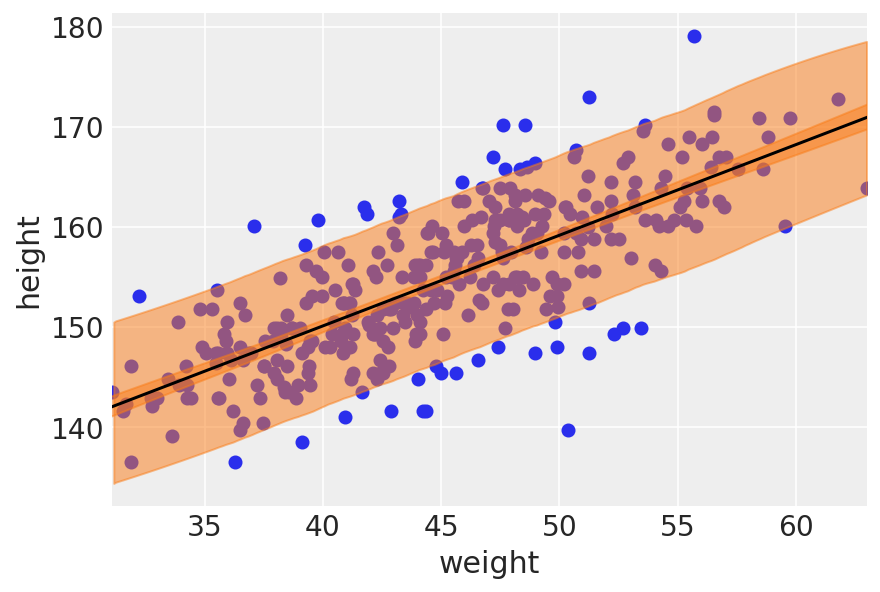

In [81]:
# plot the raw data
plt.scatter(d2.weight, d2.height)
# plot the most likely line
plt.plot(weight_seq, mu_mean, "k")
# plot the uncertainty around the mean line or the HPDI
ax = az.plot_hdi(weight_seq, mu_pred.T, hdi_prob=0.89)
# plot the compatibility interval
az.plot_hdi(d2.weight, height_pred.posterior_predictive["height"], ax=ax, hdi_prob=0.89)
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.62

Change the number of samples used in 4.59 (200) to other values.

/home/guy/Applications/anaconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/plots/hdiplot.py:157: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


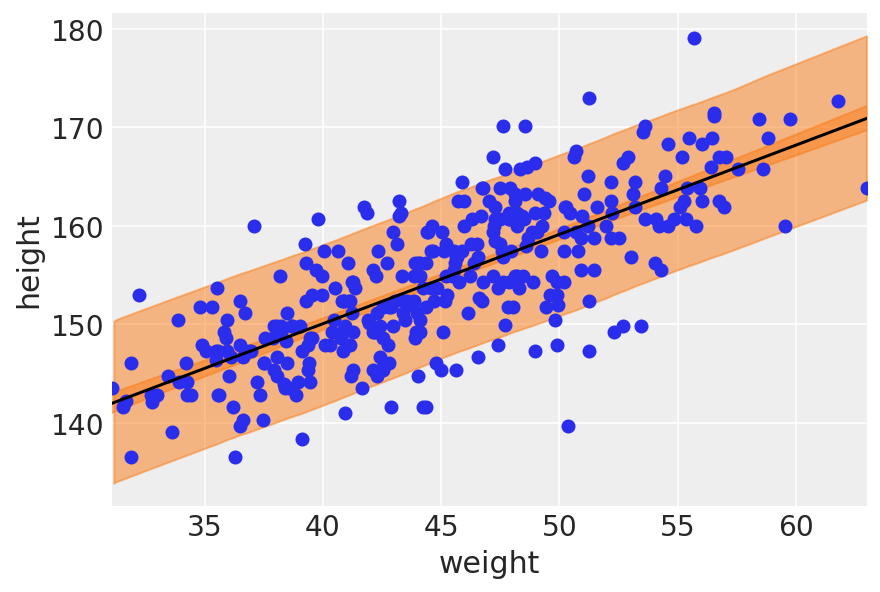

In [82]:
samp_size = 1000
slice_rate = int(len(trace_4_3["posterior"]["draw"]) / samp_size)
thin_data = trace_4_3.sel(draw=slice(None, None, slice_rate))
with m4_3:
    height_pred = pm.sample_posterior_predictive(thin_data)
ax = az.plot_hdi(weight_seq, mu_pred.T)
az.plot_hdi(d2.weight, height_pred.posterior_predictive["height"], ax=ax, hdi_prob=0.89)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.63

Now we are going to generate heights from the posterior *manually*. Instead of restricting ourselves to the input values, we are going to pass an array of equally spaced weights values, called `weight_seg`.  One way to randomize is to randomly choose one of the chains to take the paramaters `a` and `b` from.

In [83]:
weight_seq = np.arange(25, 71)
post_samples = []
for _ in range(1000):  # number of samples from the posterior
    # pick a random chain to use for the paramaters "a" and "b"
    i = height_rng.integers(len(data_4_3))
    mu_pr = data_4_3["a"][i].item(0) + data_4_3["b"][i].item(0) * (weight_seq - d2.weight.mean())
    sigma_pred = data_4_3["sigma"][i]
    post_samples.append(height_rng.normal(mu_pr, sigma_pred))

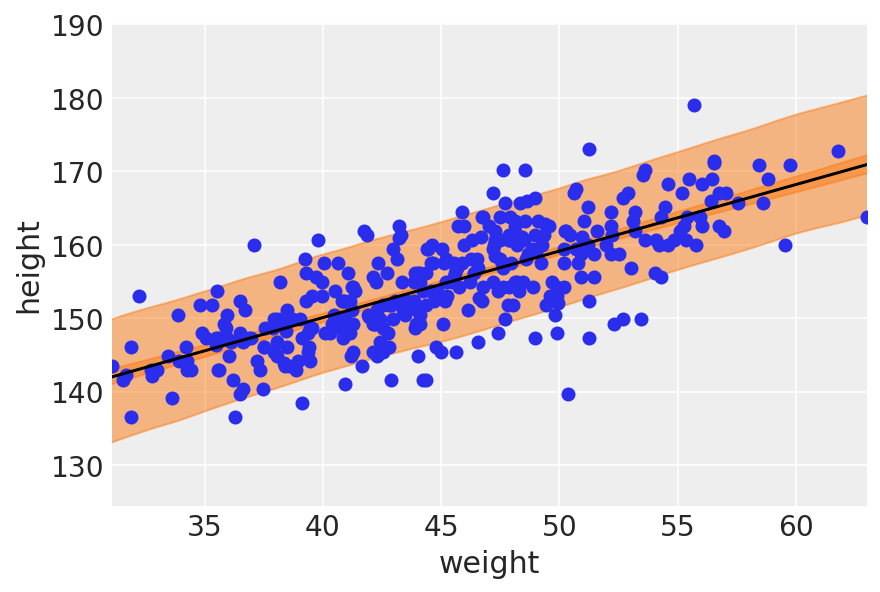

In [84]:
ax = az.plot_hdi(weight_seq, mu_pred.T, hdi_prob=0.89)
az.plot_hdi(weight_seq, np.array(post_samples), ax=ax, hdi_prob=0.89)
plt.scatter(d2.weight, d2.height)
plt.plot(weight_seq, mu_mean, "k")
plt.xlabel("weight")
plt.ylabel("height")
plt.xlim(d2.weight.min(), d2.weight.max());

#### Code 4.64

We have already loaded this dataset, check code 4.7 and 4.8.

In [85]:
print(d.head())
print(d.shape)

    height     weight   age  male
0  151.765  47.825606  63.0     1
1  139.700  36.485807  63.0     0
2  136.525  31.864838  65.0     0
3  156.845  53.041914  41.0     1
4  145.415  41.276872  51.0     0
(544, 4)


Text(0.5, 0, 'weight')

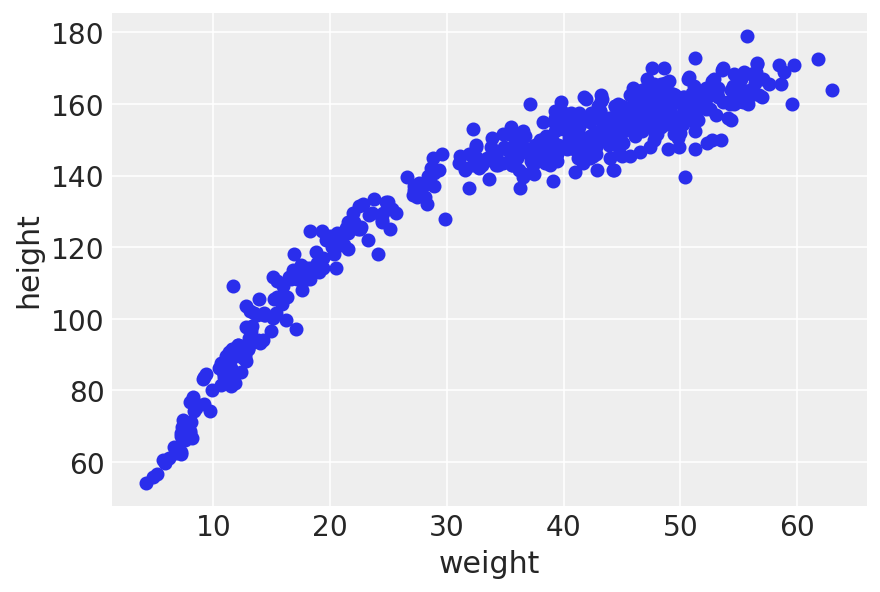

In [86]:
plt.scatter(d.weight, d.height)
plt.ylabel("height")
plt.xlabel("weight")

#### Code 4.65

In [87]:
# Standardize the weight - that is encode the weights
# as relative to the mean and standard deviation
d["weight_std"] = (d.weight - d.weight.mean()) / d.weight.std()
# and square the standardized weights.
d["weight_std2"] = d.weight_std**2

with pm.Model() as m_4_5:
    a = pm.Normal("a", mu=178, sigma=20)
    # height should be a positive correlate of weight
    b1 = pm.Lognormal("b1", mu=0, sigma=1)
    # but we don't want to impose a prior on the curvature.  The exercises will show us why.
    b2 = pm.Normal("b2", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    # our new deterministic varriable now depends on two normaly distributed paramaters
    # b1 and b2 where we are taking a linear combination of the weight and the squared weight
    # together with the intercept to come up with a prediction of mu
    mu = pm.Deterministic("mu", a + b1 * d.weight_std.values + b2 * d.weight_std2.values)
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values)
    trace_4_5 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b1, b2, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.


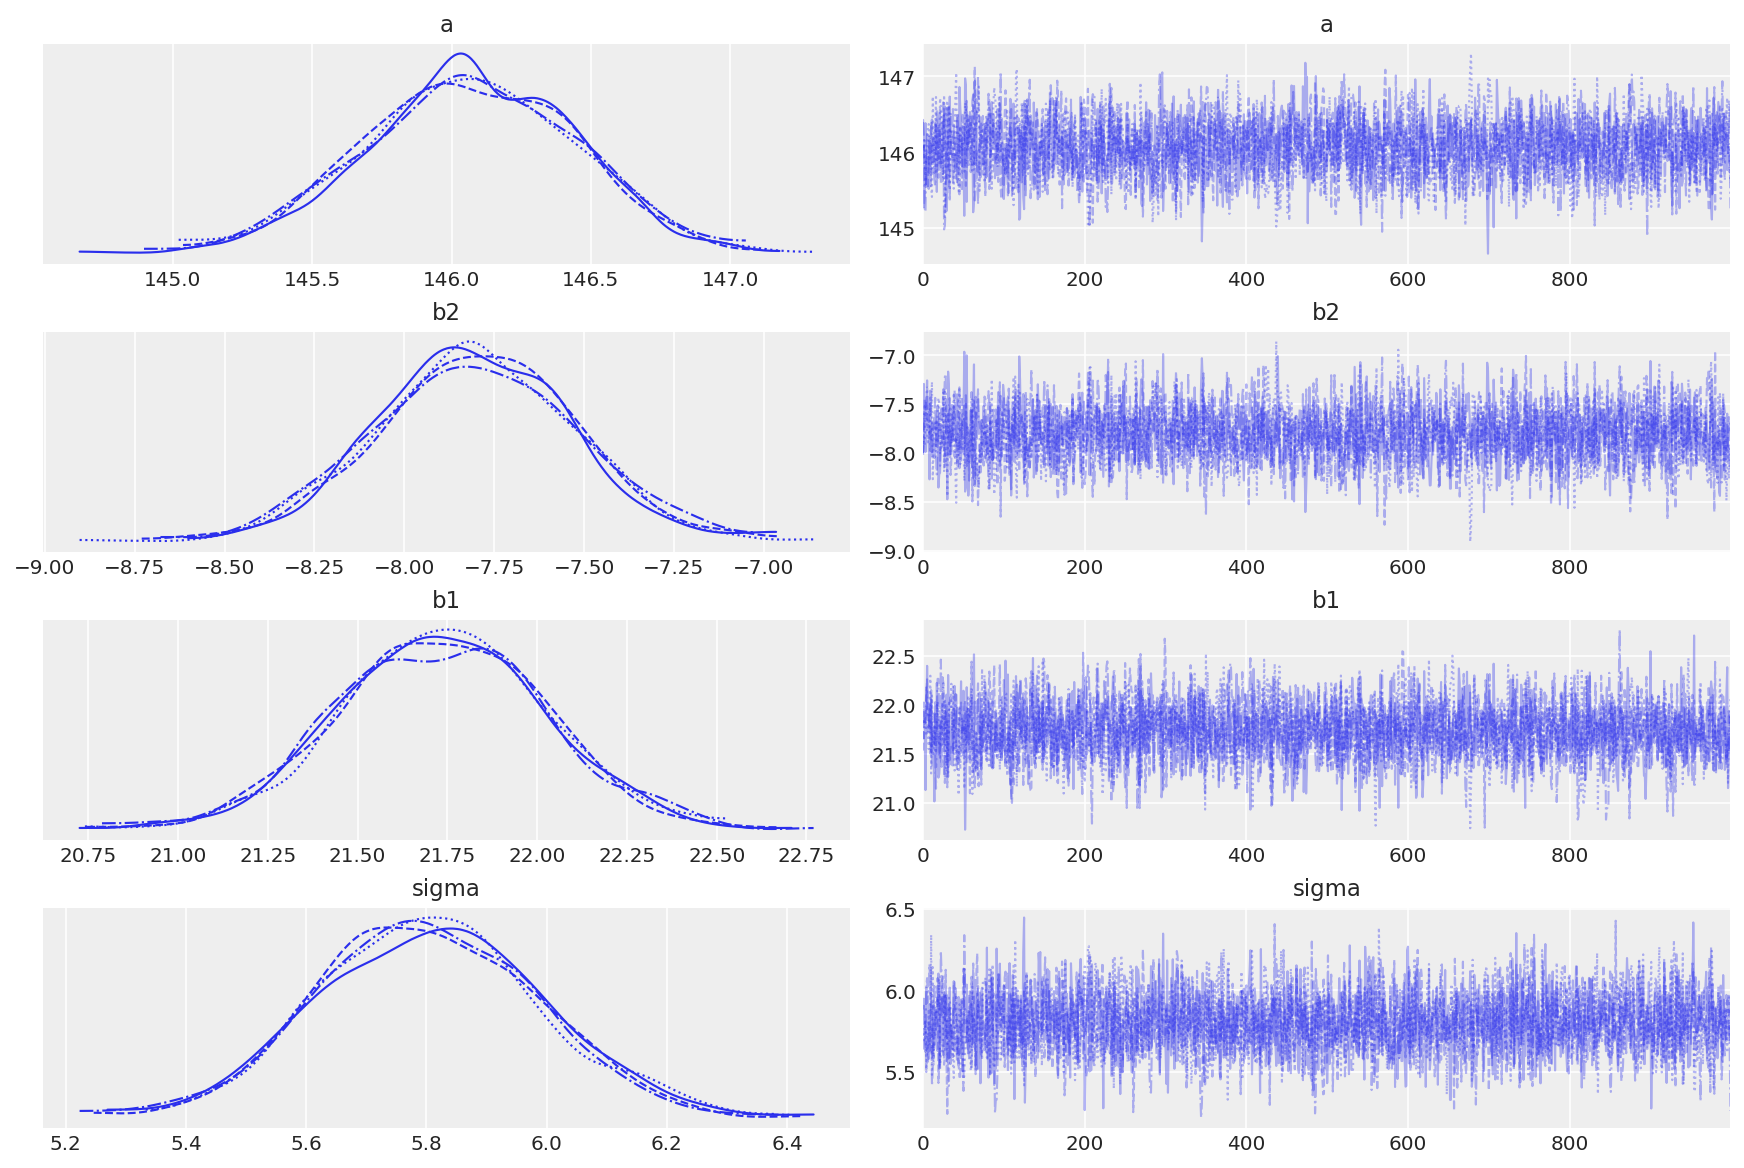

In [88]:
varnames = ["~mu"]
az.plot_trace(trace_4_5, varnames);

#### Code 4.66

In [89]:
az.summary(trace_4_5, varnames, kind="stats", round_to=2)

mean    sd  hdi_5.5%  hdi_94.5%
a      146.06  0.37    145.47     146.66
b2      -7.80  0.28     -8.26      -7.38
b1      21.73  0.29     21.27      22.18
sigma    5.80  0.18      5.51       6.10

#### Code 4.67

In [90]:
mu_pred = trace_4_5.posterior["mu"]
trace_4_5_thinned = trace_4_5.sel(draw=slice(None, None, 5))
with m_4_5:
    height_pred = pm.sample_posterior_predictive(trace_4_5_thinned)

#### Code 4.68

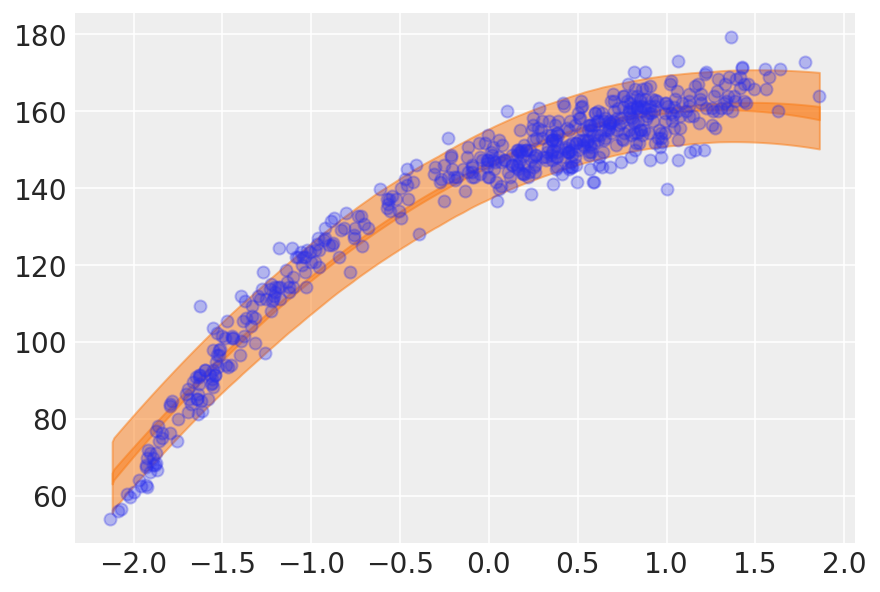

In [91]:
ax = az.plot_hdi(d.weight_std, mu_pred, hdi_prob=0.89)
az.plot_hdi(d.weight_std, height_pred.posterior_predictive["height"], ax=ax, hdi_prob=0.89)
plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3)

#### Code 4.69

Here we define a new model using a cubic polynomial as a model for predicting $\mu_i$.  Since it is a cubic, the model will have:
$$\mu_i = \alpha + \beta_1 x_i + \beta_2 x_i + \beta_3 x_i$$

Written another way $$\mu_i = \alpha + (\mathbf{x} \cdot \mathbf{\beta})$$
So we will stack the weights to get a 2D array, this simplifies writing a model.

In [92]:
weight_m = np.vstack((d.weight_std, d.weight_std**2, d.weight_std**3))

In [93]:
with pm.Model() as m_4_6:
    a = pm.Normal("a", mu=178, sigma=100)
    # note the shape=3 means that this is a 3-D vector
    b = pm.Normal("b", mu=0, sigma=10, shape=3)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + pm.math.dot(b, weight_m))
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values)
    trace_4_6 = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


#### Code 4.70 and 4.71

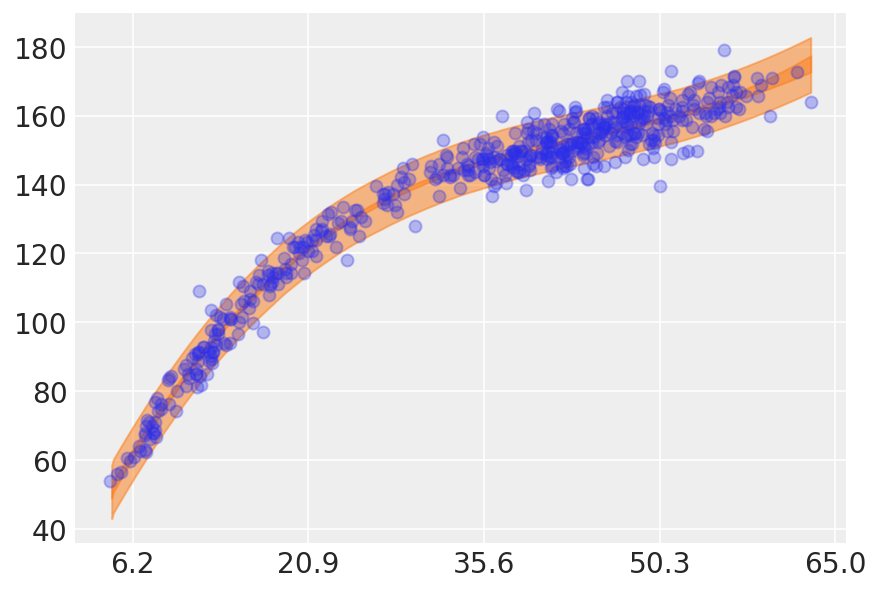

In [94]:
mu_pred = trace_4_6.posterior["mu"]
trace_4_6_thin = trace_4_6.sel(draw=slice(None, None, 5))
with m_4_6:
    height_pred = pm.sample_posterior_predictive(trace_4_6_thin)

ax = az.plot_hdi(d.weight_std, mu_pred, hdi_prob=0.89)
az.plot_hdi(d.weight_std, height_pred.posterior_predictive["height"], ax=ax, hdi_prob=0.89)
plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3)

# convert x-axis back to original scale
at = np.arange(-2, 3)
labels = np.round(at * d.weight.std() + d.weight.mean(), 1)
plt.xticks(at, labels);

What does fitting a linear model look like on the whole dataset?

In [95]:
w_bar = d.weight.mean()
with pm.Model() as m_4_7:
    a = pm.Normal("a", mu=178, sigma=20)
    b = pm.LogNormal("b", mu=0, sigma=1)
    sigma = pm.Uniform("sigma", lower=0, upper=50)
    mu = pm.Deterministic("mu", a + b * (d.weight.values - w_bar))
    height = pm.Normal("height", mu=mu, sigma=sigma, observed=d.height.values)
    trace_4_7 = pm.sample(1000, tune=1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


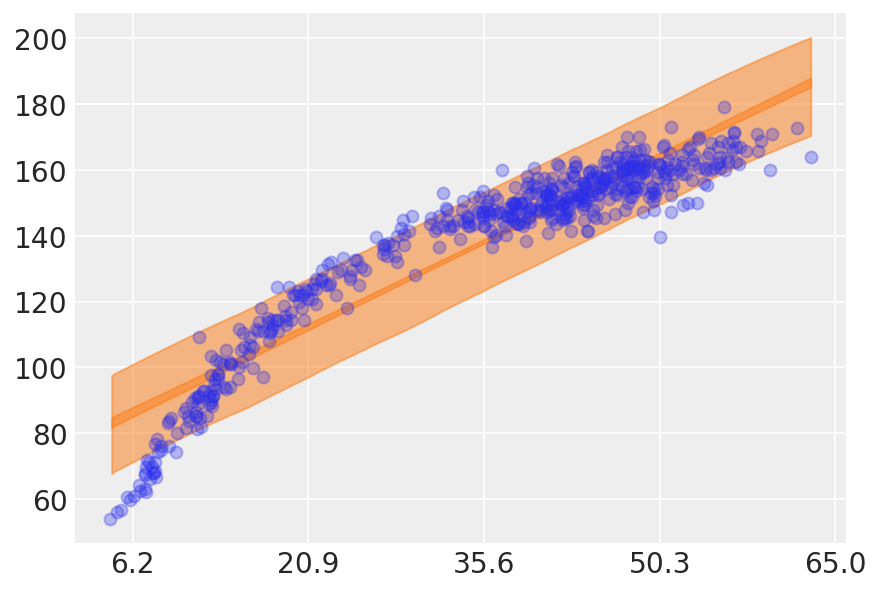

In [96]:
mu_pred = trace_4_7.posterior["mu"]
trace_4_7_thin = trace_4_7.sel(draw=slice(None, None, 5))
with m_4_7:
    height_pred = pm.sample_posterior_predictive(trace_4_7_thin)

ax = az.plot_hdi(d.weight_std, mu_pred, hdi_prob=0.89)
az.plot_hdi(d.weight_std, height_pred.posterior_predictive["height"], ax=ax, hdi_prob=0.89)
plt.scatter(d.weight_std, d.height, c="C0", alpha=0.3)

# convert x-axis back to original scale
at = np.arange(-2, 3)
labels = np.round(at * d.weight.std() + d.weight.mean(), 1)
plt.xticks(at, labels);

Not very good.

### 4.5.2 Splines

#### Code 4.72

In [97]:
d = pd.read_csv("Data/cherry_blossoms.csv")
# nans are not treated as in the book
az.summary(d.dropna().to_dict(orient="list"), kind="stats")

mean       sd  hdi_5.5%  hdi_94.5%
year        1533.395  291.123   1123.00    1978.00
doy          104.921    6.258     95.00     114.00
temp           6.100    0.683      5.00       7.13
temp_upper     6.938    0.812      5.57       7.98
temp_lower     5.264    0.762      4.12       6.40

Text(0, 0.5, 'temperature')

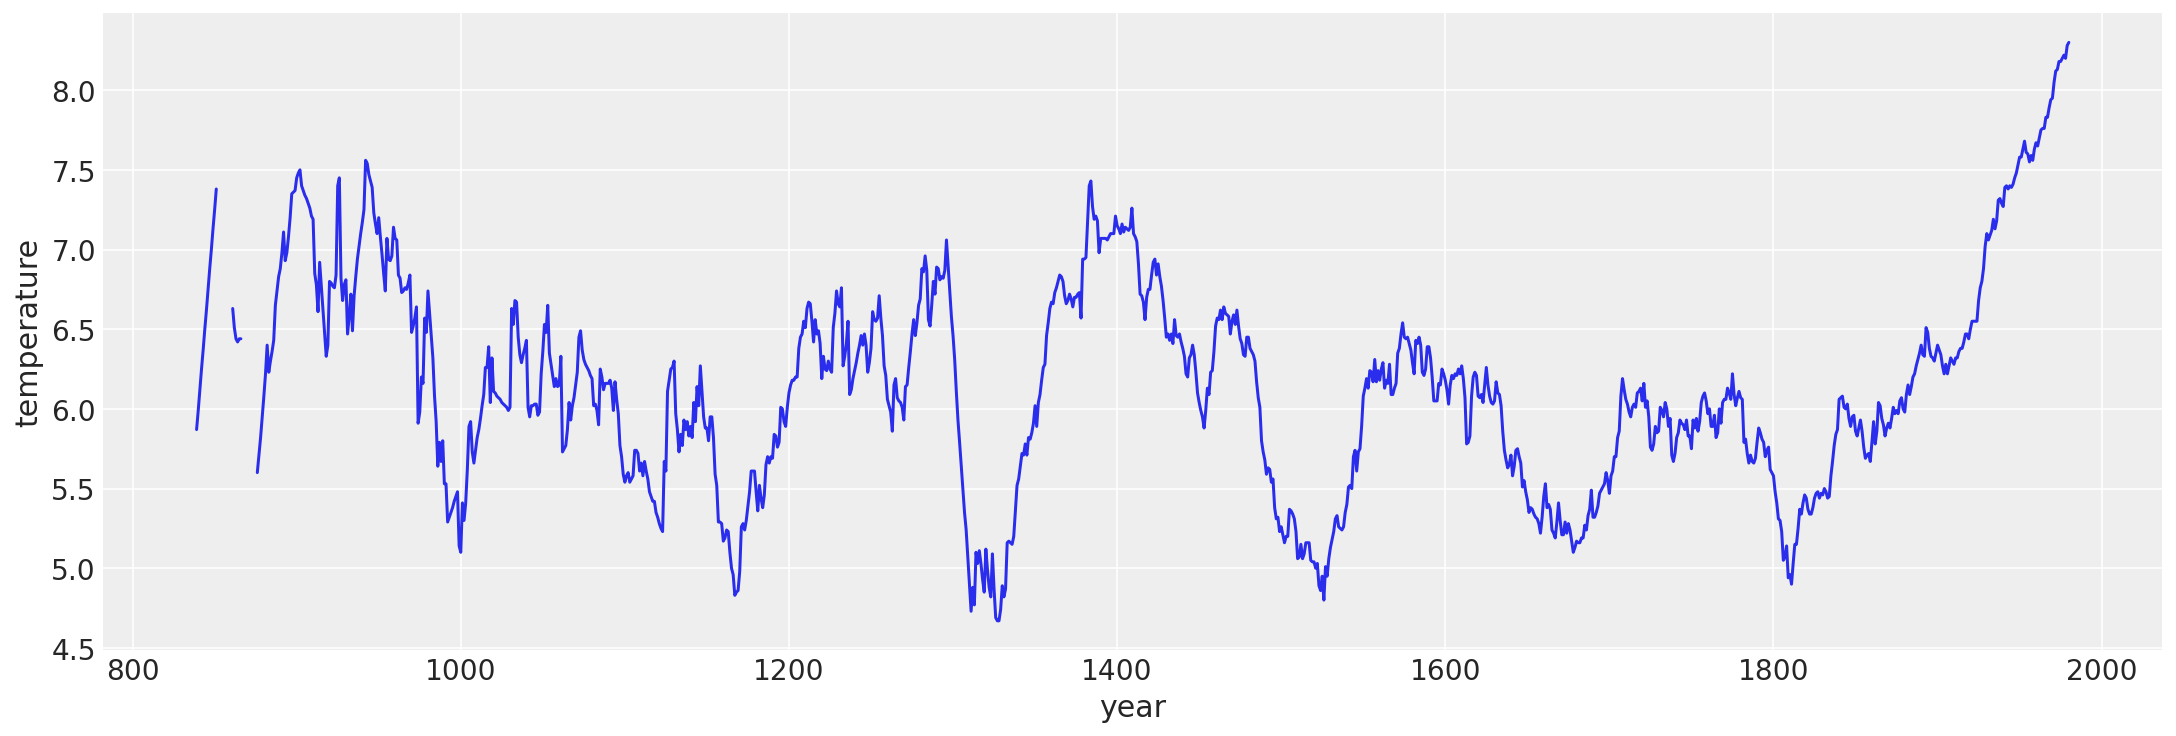

In [98]:
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(d.year, d.temp)
plt.xlabel("year")
plt.ylabel("temperature")

There are lot's of software packages that can generate B-splines and fit them to data.  For example the `scipy.interpolate` library has an implementation.  But for the sake of illustration, lets use the Cox-de Boor recursive definition of basis slines.  This is what is refered to in the text as "basis variables".

Given a knot sequence of $\dots \mathit{t}_0, \mathit{t}_1, \mathit{t}_{2}, \dots$ the B-splines of order 1 are given by
$$ B_{i,0}(x) = 
\begin{cases}
1 \text{ for } \mathit{t}_i \le x \lt \mathit{t}_{i+1}\\
0 \text{ otherwise}
\end{cases}$$

And splines of order $k$ are defined as
$$B_{i,k}(x) =
\frac{x - \mathit{t}_i}{\mathit{t}_{i+k} - \mathit{t}_i} B_{i,k-1}(x) +
\frac{\mathit{t}_{i+k+1} - x}{\mathit{t}_{i+k+1} - \mathit{t}_{i+1}} B_{i+1,k-1}(x)
$$

That is a lot to digest.  However if we look at the terms that are multiplying the lower order B-splines we can see that the first term is saying something about how close we are to the knot $\mathit{t}_{i}$ relative to the distance from $\mathit{t}_i$ to $\mathit{t}_{i+k}$ and the second term is saying something about how far we are from $\mathit{t}_{i+k+1}$ relative to the distance between $\mathit{t}_{i+k+1}$ and $\mathit{t}_{i+1}$. Also notice how as $x$ increases from $\mathit{t}_{i}$ to $\mathit{t}_{i+k}$, the expression $\frac{x - \mathit{t}_i}{\mathit{t}_{i+k} - \mathit{t}_i}$ increases from 0 to 1 and as $x$ increases from $\mathit{t}_{i+k}$ to $\mathit{t}_{i+k+1}$, the expression $\frac{\mathit{t}_{i+k+1} - x}{\mathit{t}_{i+k+1} - \mathit{t}_{i+k}}$ decreases from 1 to 0.

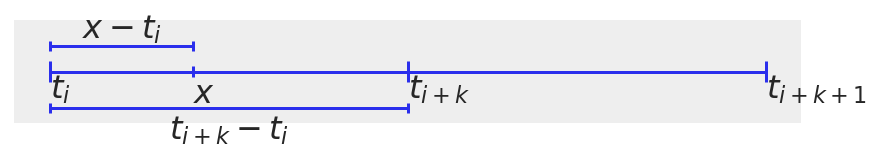

In [99]:
fig, ax = plt.subplots(figsize=(6,1))
def draw_interval(ax=ax, start=0, stop=1, y_pos=0, text="", y_height=0.05, pos="above"):
    ax.hlines(y_pos,start, stop)
    ax.vlines([start,stop],y_pos-y_height, y_pos+y_height)
    if pos == "above":
        text_pos = y_pos * 1.1
    else:
        text_pos = y_pos - 0.3
    ax.text(start+(stop-start)/2,text_pos,
        text,
        horizontalalignment="center"
    )

def define_axes(ax=ax):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.hlines(0.5, 1, 3)
    ax.set_ylim(0,1)
    ax.vlines([1,2,3], 0.4, 0.6, )
    plt.rcParams.update({'font.size': 16})
    
def draw_num_line(ax=ax):
    y_text = 0.25
    ax.text(1, y_text,"$\mathit{t}_{i}$")
    ax.text(2, y_text, "$\mathit{t}_{i+k}$")
    ax.text(3, y_text, "$\mathit{t}_{i+k+1}$")

define_axes(ax)
draw_num_line(ax)
y_text = 0.2
ax.vlines(1.4, 0.45,0.55)
ax.text(1.4, y_text, "$x$")
draw_interval(ax,1,1.4,0.75,"$x - \mathit{t}_i$",0.05)
draw_interval(ax,1,2,0.15,"$\mathit{t}_{i+k} - \mathit{t}_i$",0.05, pos='below')
plt.show()

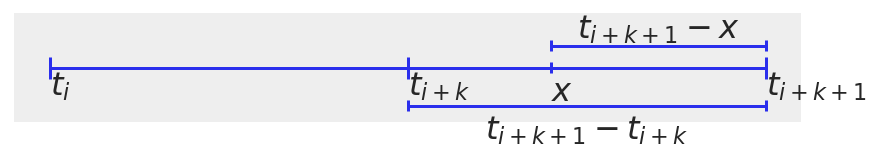

In [100]:
fig, ax = plt.subplots(figsize=(6,1))
define_axes(ax)
draw_num_line(ax)
ax.vlines(2.4, 0.45,0.55)
ax.text(2.4, y_text, "$x$")
draw_interval(ax,2.4,3,0.7,"$\mathit{t}_{i+k+1} - x$",0.05)
draw_interval(ax,2,3,0.15,"$\mathit{t}_{i+k+1} - \mathit{t}_{i+k}$",0.05, pos='below')

Here is some code that will implement basis splines using the Cox-de Boor recursive definition.

In [101]:
def B(x, k, i, t):
    if k == 0:
        return 1.0 if t[i] <= x < t[i+1] else 0.0
    if t[i+k] == t[i]:
        c1 = 0.0
    else:
        c1 = (x - t[i])/(t[i+k] - t[i]) * B(x, k-1, i, t)
    if t[i+k+1] == t[i+1]:
        c2 = 0.0
    else:
        c2 = (t[i+k+1] - x)/(t[i+k+1] - t[i+1]) * B(x, k-1, i+1, t)
    return c1 + c2

Using this definition we can draw out the five basis splines that are used in the figure 4.12

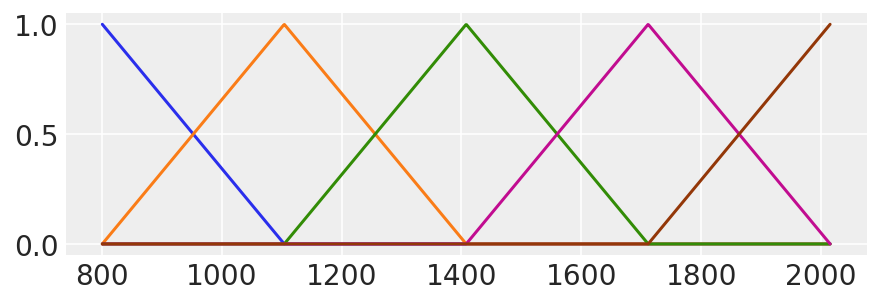

In [103]:
# generate a sequence of five evenly spaced points
t = np.linspace(d.year.min(), d.year.max(), 5)
# extend both ends of these in order to be able to compute the end basis splines
delta_t = t[1]-t[0]
t1=[]
t1.append(t[0] - delta_t)
t1 += t.tolist()
t1.append(t[4]+ delta_t)
fig, ax = plt.subplots(figsize=(6,2))
xx = np.linspace(t[0], t[4], 1000)
for i in range(len(t)):
    ax.plot(xx, [B(x,1,0,[t1[i],t1[i+1],t1[i+2]]) for x in xx])
ax.grid(True)
plt.show()

By taking linear combinations of these five functions we can generate a curve that is piecwise linear between the knots.  To see that first we define a helper function that will generate the basis splines.  Then we define a function that will take a linear combination of those splines.

In [104]:
def B_i(x, i):
    return B(x,1,0,[t1[i], t1[i+1], t1[i+2]])

def splineF(x, c):
    # x = value to evaluate at
    # c = list of weights to use on each basis function
    val = 0
    for i, weight in enumerate(c):
        val += weight * B_i(x,i)
    return val

Now, lets plot each of the basis functions defined above when they get multiplied by some weight value.  In this case we call the weight vector `c`.

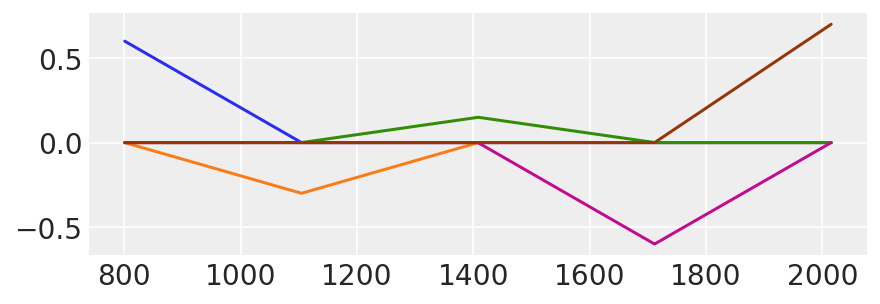

In [105]:
xx = np.linspace(t[0], t[4], 1000)
c = [0.6,-0.3,0.15,-0.6,0.7]
fig, ax = plt.subplots(figsize=(6,2))
for i in range(len(c)):
    ax.plot(xx, [c[i]* B_i(x,i) for x in xx])
ax.grid(True)
plt.show()

and taking the linear combination leads to this line

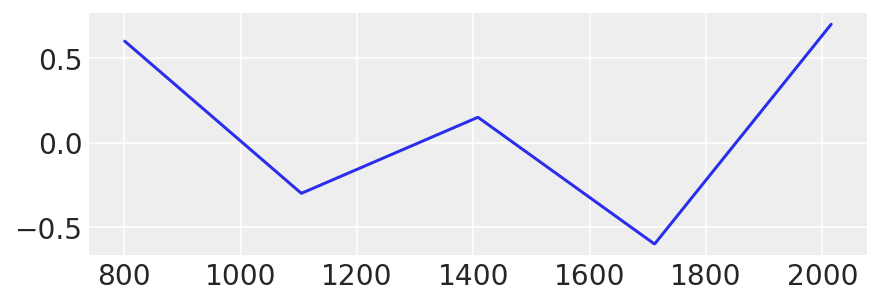

In [106]:
fig, ax = plt.subplots(figsize=(6,2))
xx = np.linspace(t[0], t[4], 1000)
ax.plot(xx, [splineF(x,c) for x in xx])
ax.grid(True)
plt.show()

That is the general method that is used to fit a picewise polynomial to some data.  How does this get done in practice?

The [PyMC Examples](https://www.pymc.io/projects/examples/en/latest/case_studies/spline.html?highlight=b-splines) page goes through this process and uses the same data however it fits a model to predict the day of first blossom (that is called "number of days in bloom"). Here we are going to fit a model to represent the temperature on the first day of bloom.  The procedures are the same for both.



#### Code 4.73

We exclude incomplete data from our model and generate 15 knots based on 15 equal quantiles.

In [107]:
d2 = d.dropna(subset=["temp"])
num_knots = 15
knot_list = np.quantile(d2.year, np.linspace(0, 1, num_knots))

The first thing is to write the linear combination of splines portion of our model:

$$
\mu_i = \alpha + \sum_{k=1}^K w_kB_{k,i} \newline
$$

This can be written as a matrix product

$$
\mathbf{\mu} = \alpha + \bf{w} \cdot \bf{B}
$$

Where if we have $k$ splines, $\mathbf{w} = (w_0, w_1, \dots , w_k)$ is the vector of weights (or sometimes called coeficients) and $\mathbf{B}$ is a matrix. The rows correspond to the years in our data.  The columns then are the value each of the basis splines take at that point. That will result in a collection of equations, one for each point in our data.

That sounds like a lot of work to build, but there are tools for that.  We will use the [patsy](https://patsy.readthedocs.io/en/latest/index.html) library as a simple way of building the b-spline matrix.  Note that you might have to `pip install patsy` in your environment as it is not part of the PyMC packages.

What the code below is doing is creating  `DesignMatrix` object which is a numpy array with associated metadata.  The first argument to `patsy.dmatrix` is the formula that it will create the matrix for.  To get that formula we use the `patsy.bs()` function.  It is identical to the `R` function `bs()` in that you tell it what your data is, what degree of splines you want to use, and what knots you want to use.  For more details you can look at [spline regresson using patsy](https://patsy.readthedocs.io/en/latest/spline-regression.html).

#### Code 4.74

In [108]:
from patsy import dmatrix

B = dmatrix(
    "bs(year, knots=knots, degree=3, include_intercept=True)-1",
    {"year": d2.year.values, "knots": knot_list[1:-1]},
)
B.shape

(1124, 17)

#### Code 4.75

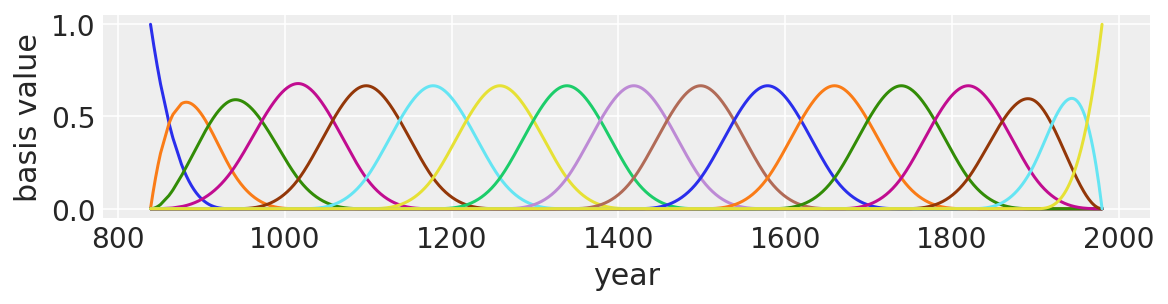

In [109]:
_, ax = plt.subplots(1, 1, figsize=(8, 2))
for i in range(B.shape[1]):
    ax.plot(d2.year, (B[:, i]))
ax.set_xlabel("year")
ax.set_ylabel("basis value");

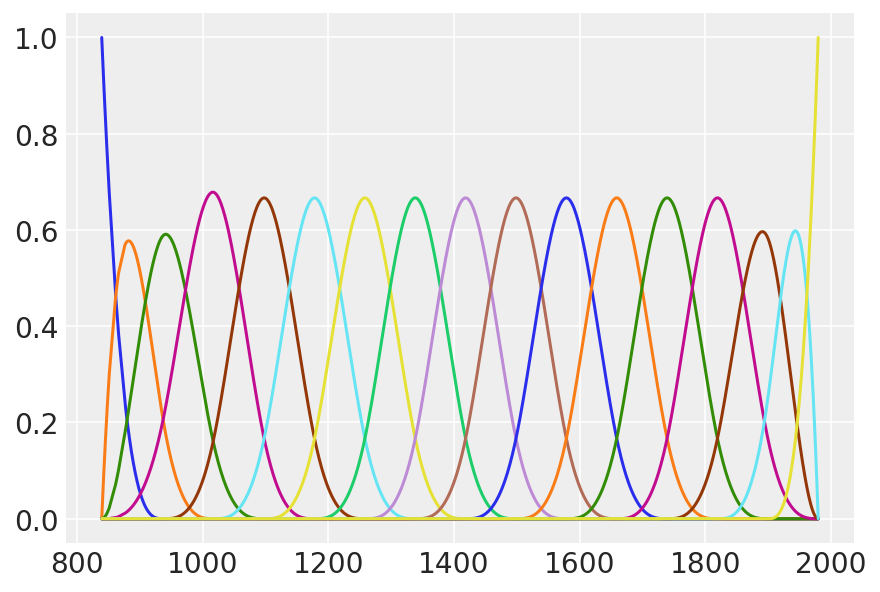

In [110]:
plt.plot(d2.year, B)

In [111]:
B2 = dmatrix(
    "bs(year, df=17, degree=3, include_intercept=False)-1",
    {"year": d2.year.values},
)
B2.base

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.17662503e-02, 1.91255021e-04, 2.64624450e-07, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [6.24655338e-02, 7.59665473e-04, 2.11699560e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.05299364e-03, 7.69644301e-02, 9.21979399e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.65432880e-04, 3.92725561e-02, 9.60461614e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [112]:
B.design_info

DesignInfo(['bs(year, knots=knots, degree=3, include_intercept=True)[0]',
            'bs(year, knots=knots, degree=3, include_intercept=True)[1]',
            'bs(year, knots=knots, degree=3, include_intercept=True)[2]',
            'bs(year, knots=knots, degree=3, include_intercept=True)[3]',
            'bs(year, knots=knots, degree=3, include_intercept=True)[4]',
            'bs(year, knots=knots, degree=3, include_intercept=True)[5]',
            'bs(year, knots=knots, degree=3, include_intercept=True)[6]',
            'bs(year, knots=knots, degree=3, include_intercept=True)[7]',
            'bs(year, knots=knots, degree=3, include_intercept=True)[8]',
            'bs(year, knots=knots, degree=3, include_intercept=True)[9]',
            'bs(year, knots=knots, degree=3, include_intercept=True)[10]',
            'bs(year, knots=knots, degree=3, include_intercept=True)[11]',
            'bs(year, knots=knots, degree=3, include_intercept=True)[12]',
            'bs(year, knots=knots, 

#### Code 4.76

Note: if the model gets stalled instead of sampling try replacing `mu = pm.Deterministic("mu", a + pm.math.dot(B.base, w.T))` with `mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w.T))`

In [113]:
with pm.Model() as m4_8:
    a = pm.Normal("a", 6, 10)
    # Note that the size paramater is equal to the number of splines and thus
    # w is going to be a vector of length B.shape[1], the dims paramater
    # is a label for the number of dimensions that our distribution holds
    w = pm.Normal("w", mu=0, sigma=3, size=B.shape[1], dims="splines")
    mu = pm.Deterministic("mu", a + pm.math.dot(np.asarray(B, order="F"), w))
    #mu = pm.Deterministic("mu", a + pm.math.dot(B, w))
    sigma = pm.Exponential("sigma", 1)
    T = pm.Normal("T", mu=mu, sigma=sigma, observed=d2.temp.values, dims="obs")

Let's check to see that the model we have defined makes sense.

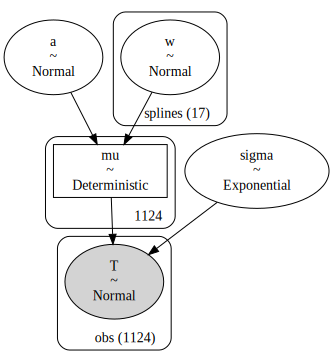

In [114]:
pm.model_to_graphviz(m4_8)

And we see that `mu` is dependent on `a`, and the weights for our splines `w`.  And `T` is dependent on `mu` and `sigma` as we wanted.

Now lets fit and sample the model.

In [115]:
with m4_8:
    trace_m4_8 = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, w, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 225 seconds.
The acceptance probability does not match the target. It is 0.9222, but should be close to 0.8. Try to increase the number of tuning steps.


#### Code 4.77

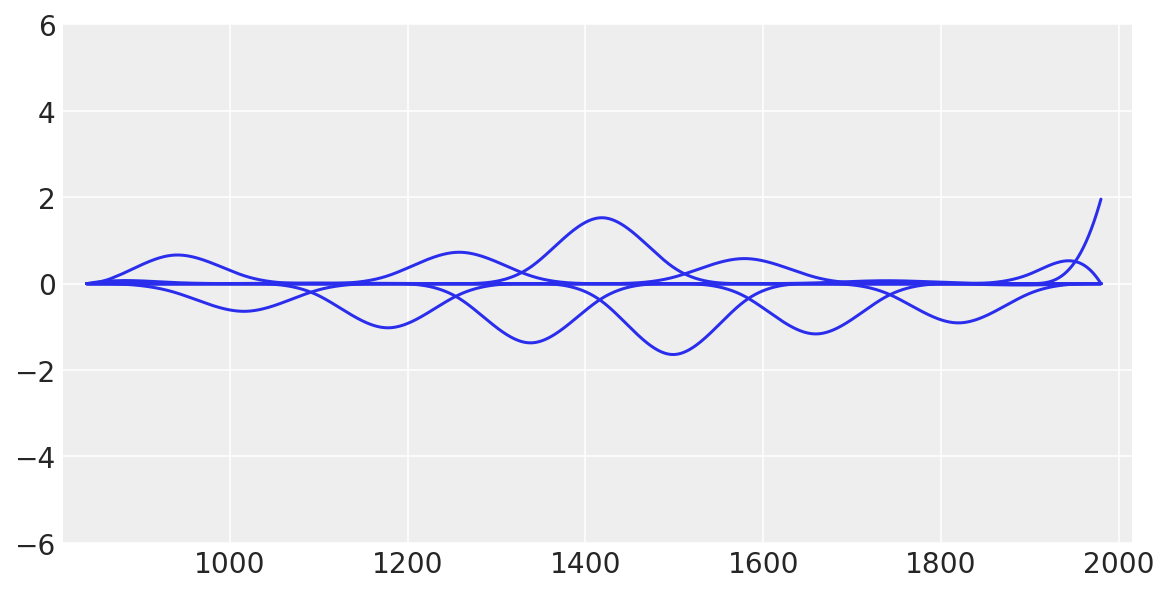

In [117]:
_, ax = plt.subplots(1, 1, figsize=(8, 4))
wp = trace_m4_8.posterior.w.mean(dim=["chain", "draw"])
for i in range(17):
    ax.plot(d2.year, (wp[i].item(0) * B[:, i]), color="C0")
ax.set_xlim(812, 2015)
ax.set_ylim(-6, 6);

#### Code 4.78

Text(0, 0.5, 'March temp')

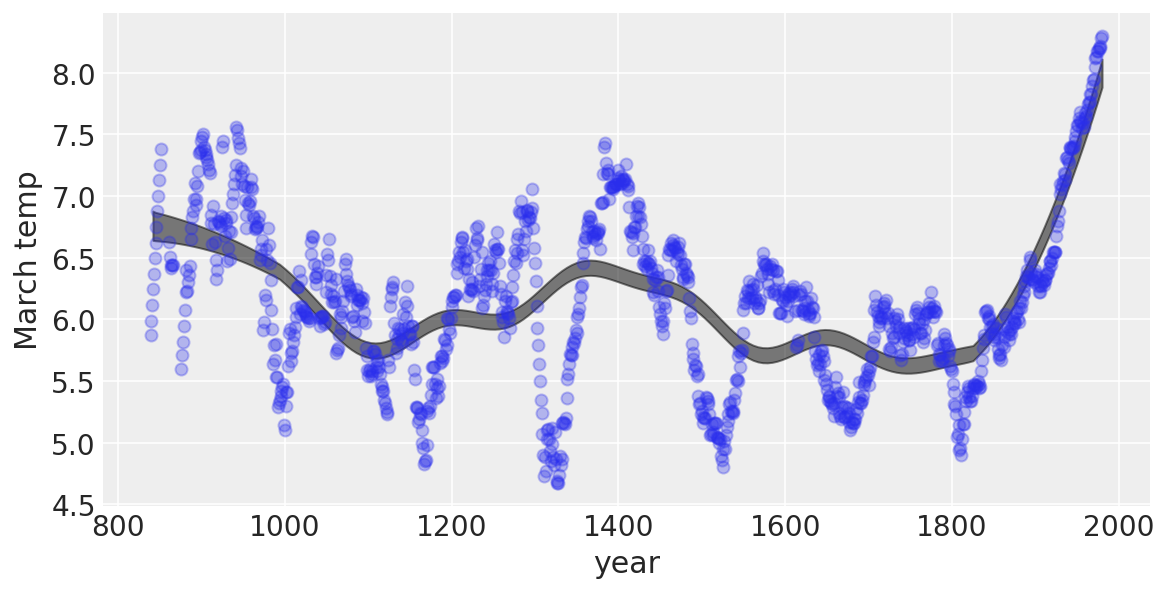

In [118]:
ax = az.plot_hdi(d2.year, trace_m4_8.posterior["mu"], color="k")
ax.plot(d2.year, d2.temp, "o", alpha=0.3)
fig = plt.gcf()
fig.set_size_inches(8, 4)
ax.set_xlabel("year")
ax.set_ylabel("March temp")

In [119]:
%load_ext watermark
%watermark -n -u -v -iv -w -p aesara,aeppl,xarray

Last updated: Fri Dec 02 2022

Python implementation: CPython
Python version       : 3.10.6
IPython version      : 8.4.0

aesara: 2.8.2
aeppl : 0.0.35
xarray: 2022.6.0

pymc      : 4.1.7
sys       : 3.10.6 | packaged by conda-forge | (main, Aug 22 2022, 20:36:39) [GCC 10.4.0]
numpy     : 1.23.3
scipy     : 1.9.1
matplotlib: 3.6.0
arviz     : 0.12.1
pandas    : 1.4.4

Watermark: 2.3.1

